In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_text, plot_intersection_bars
from helpers_barplot_intersection_kmers import explode_immunopepper_coord, search_result_peptides_ids 
from helpers_barplot_intersection_kmers import get_pep_ids, get_pep_coord, tar_reader
from helpers_barplot_intersection_kmers import validated_filtered_kmers, reader_assign_conf_pep
from helpers_barplot_intersection_kmers import compare_OHSU_ETH, kmer_in_bi_exon_peptide


Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4287461/matplotlib-44hmoqtd because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class plotting_parameters():

    def __init__(self, ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize):
        self.ticks_fontsize = ticks_fontsize
        self.axislabels_fontsize = axislabels_fontsize
        self.legend_fontsize = legend_fontsize
        self.axes_fontsize = axes_fontsize
        
    def add_saving_instructions(self, save, run_type_plot_dir, sample_plot_dir):
        self.save = save
        self.run_type_plot_dir = run_type_plot_dir #TODO simplify
        self.sample_plot_dir = sample_plot_dir  #TODO simplify
        
    def add_ticks(self, back_ticks, front_ticks):
        self.back_ticks = back_ticks
        self.front_ticks = front_ticks
        
    def add_y_label(self, y_label):
        self.y_label = y_label
        
    def add_x_label(self, xupper_axis_label, xlower_axis_label):
        self.xupper_axis_label = xupper_axis_label
        self.xlower_axis_label = xlower_axis_label
        
    def add_saving_path(self, plot_dir, base_plot, name_plot):
        self.plot_dir = plot_dir
        self.base_plot = base_plot
        self.name_plot = name_plot
    
    def add_plotting_data(self, serie_index, serie_intersection, serie_eth, serie_ohsu):
        self.serie_index = serie_index
        self.serie_intersection = serie_intersection
        self.serie_eth = serie_eth
        self.serie_ohsu = serie_ohsu

    def add_labels(self, intersection_label, eth_label, ohsu_label):
        self.intersection_label = intersection_label
        self.eth_label = eth_label
        self.ohsu_label = ohsu_label
    
    def add_color_options(self, color1, color2, color3, color4, colorgrid):
        self.color1 = color1
        self.color2 = color2
        self.color3 = color3
        self.color4 = color4
        self.colorgrid = colorgrid
    
    def edit_marker(self, marker_type, marker_size, markeredgewidth):
        self.marker_type = marker_type
        self.marker_size = marker_size
        self.markeredgewidth =  markeredgewidth
        
    def add_title(self, title):
        self.title = title
        




In [3]:
class MS_parameters():
    def __init__(self, FDR_limit):
        self.FDR_limit = FDR_limit
    def edit_pep_type(self, pep_type):
        self.pep_type = pep_type
    def edit_MS(self, MS_FDR, MS_strategy):
        self.MS_FDR = MS_FDR
        self.MS_strategy = MS_strategy
        
   

In [4]:
# INPUTS 
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'


FDR_limit = 0.05
MS_FDR_ = ['_crema', '_crux']
MS_strategy_ = ['joint', 'pool', 'single']

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline


sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'
# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = 'gold'
color2 = 'crimson'
color3 = 'mediumblue'
color4 = 'tomato'
colorgrid = 'grey'



save = True
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)

param_MS = MS_parameters(FDR_limit)

# Plot: Results per experiment

In [5]:
def run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object):
    
    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    param_object.add_plotting_data(serie_index=df_plot['index'], 
                                   serie_intersection=df_plot['pep_size_intersection'],
                                   serie_eth=df_plot['pep_size_eth'], 
                                   serie_ohsu=df_plot['pep_size_ohsu'])
    
    param_object.add_y_label('Number of MS-detected tryptic junction-peptides')
    
    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample,
                                 f'Barplot_overlap_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels('Intersection size', 'Total set size Graph Pipeline',
                            'Total set size Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')

    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot

In [6]:
def run_sample_plotting_rates(order_file, sample, df, param_MS, param_object ):
    
    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')

    back_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_background'] 
    front_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_foreground']
    param_object.add_ticks(back_ticks, front_ticks)
    

    param_object.add_plotting_data(serie_index=np.arange(len(back_ticks)), 
                                   serie_intersection=None,
                                   serie_eth=df_plot.loc[df_plot['pipeline'] == 'ETH', 'validation_rate'],
                                   serie_ohsu=df_plot.loc[df_plot['pipeline'] == 'OHSU', 'validation_rate'])
     
    param_object.add_y_label('Validation rate')

    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample, 
                                 f'Barplot_val_rate_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels('Intersection size', 'Graph Pipeline',
                            'Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')
    
    plot_intersection_bars(param_object)


    return df_plot

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


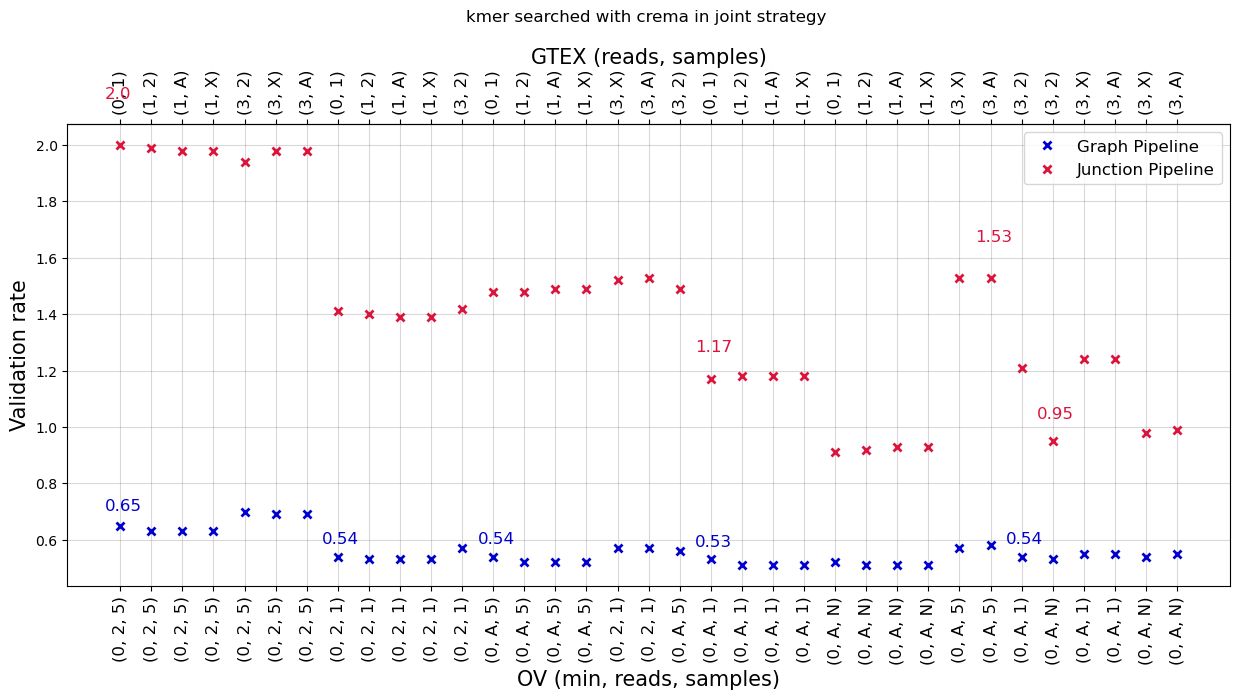

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


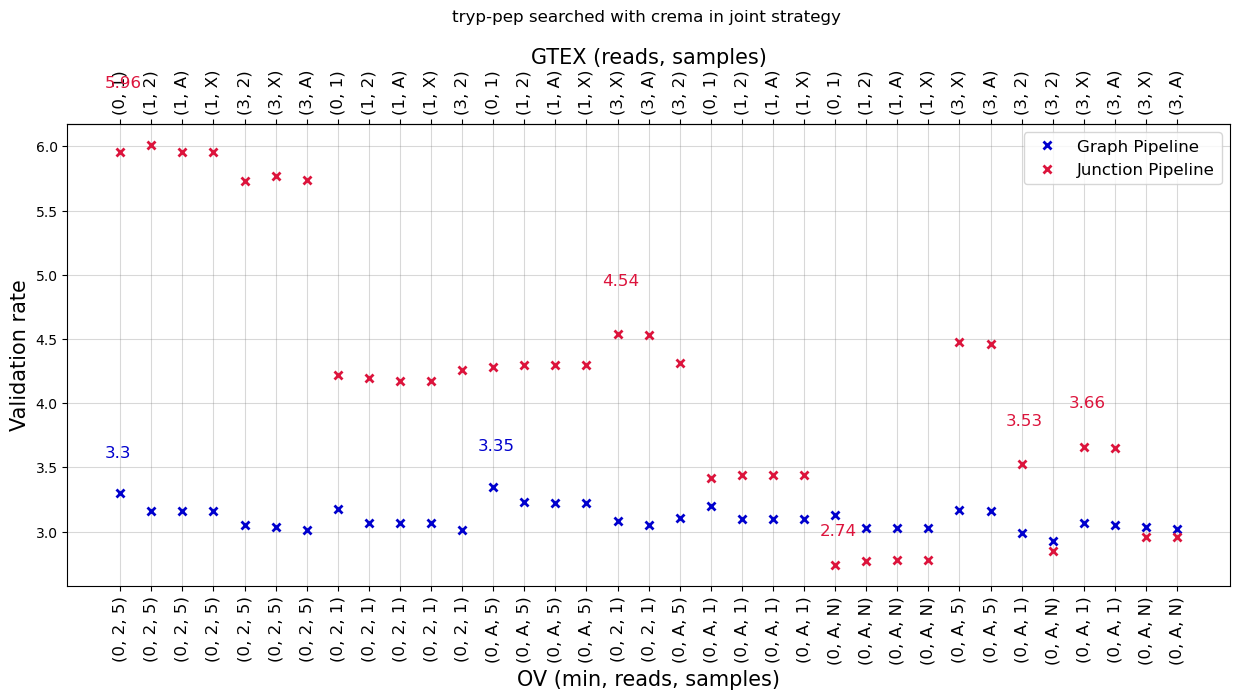

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


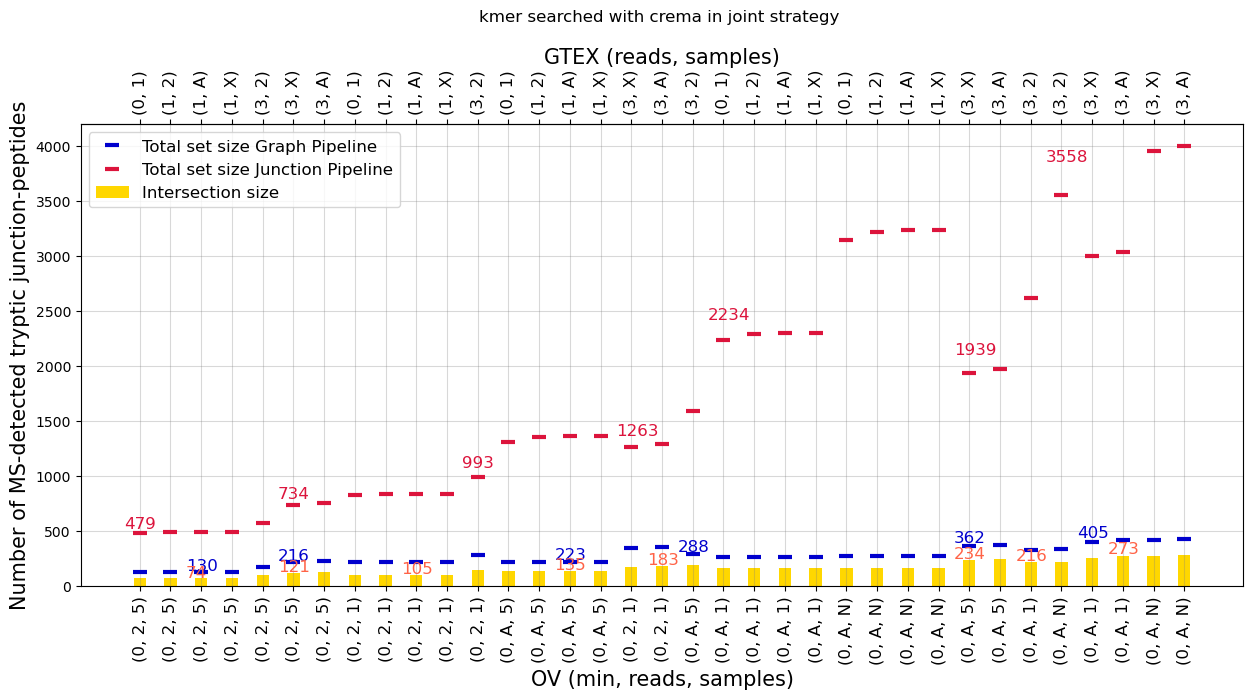

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


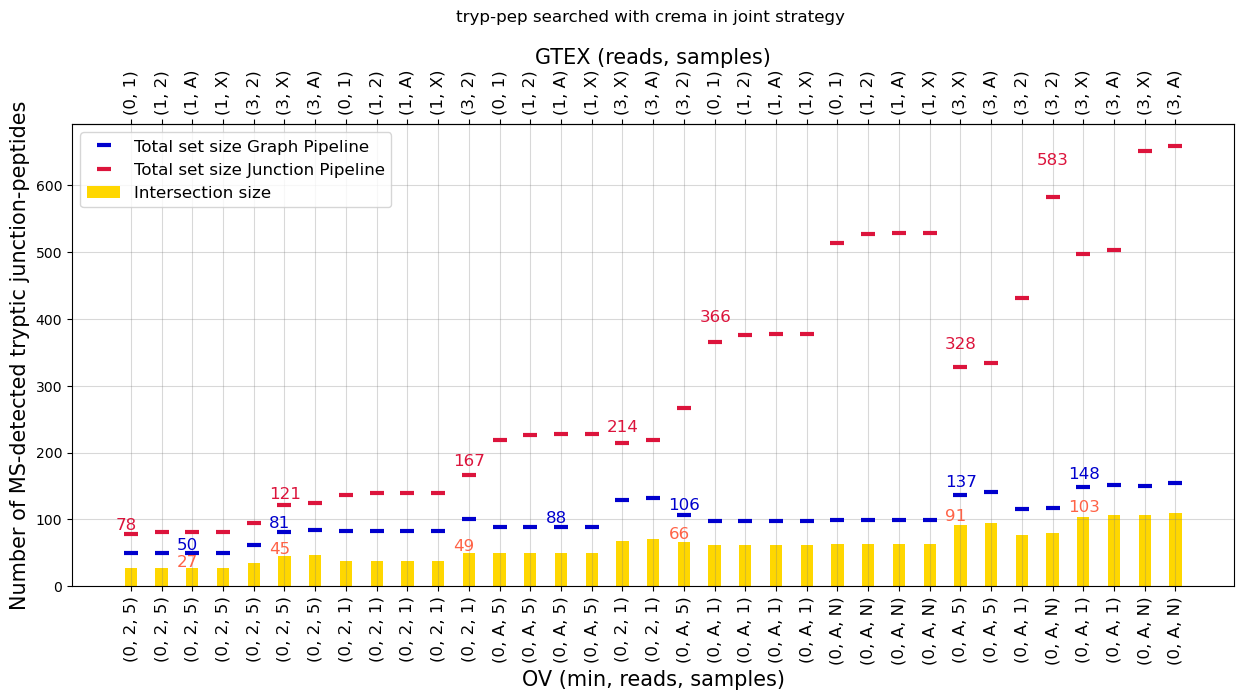

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


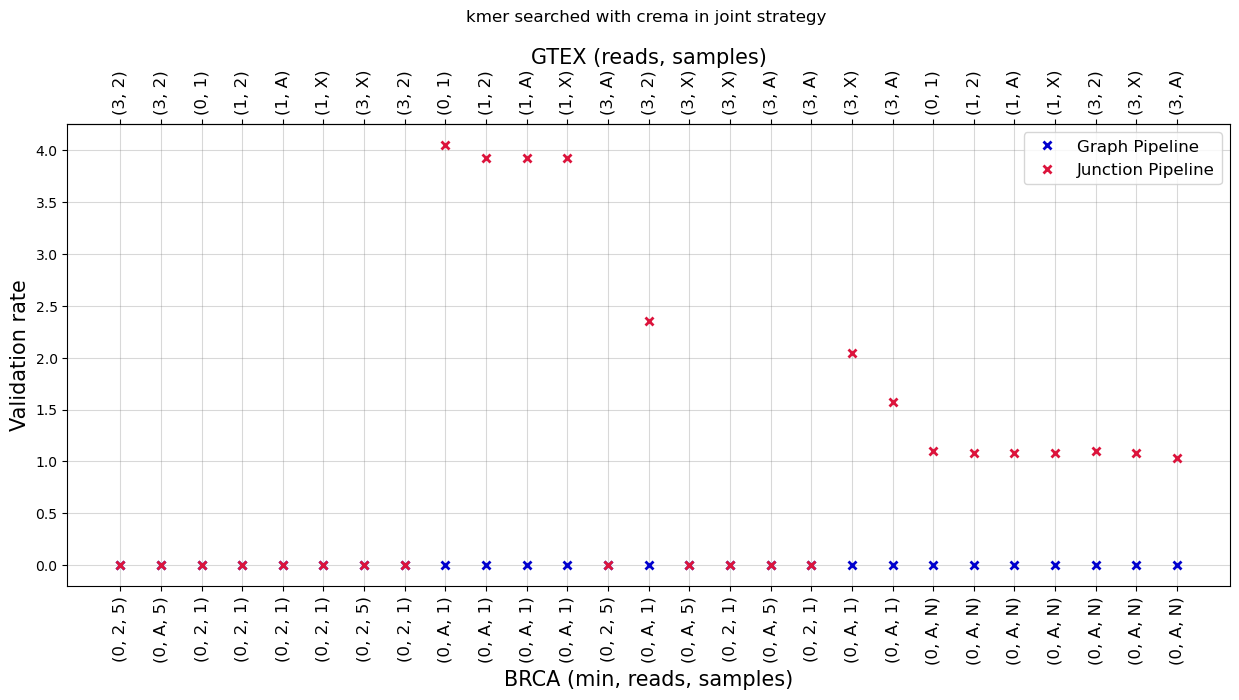

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


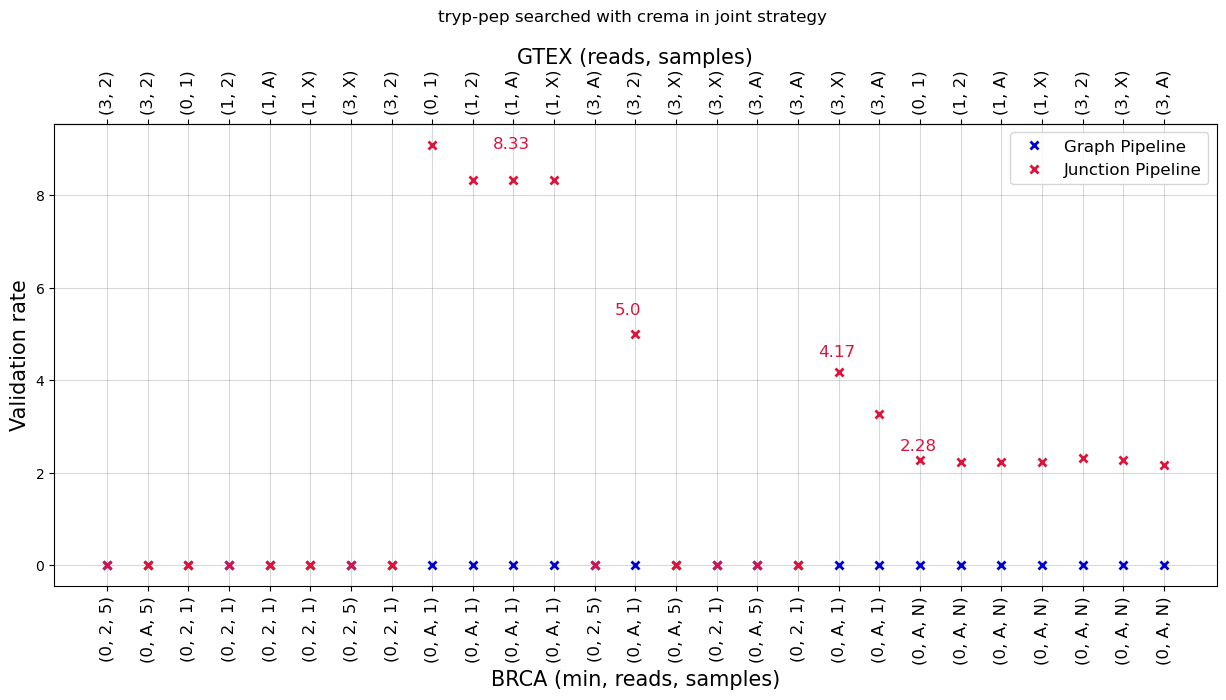

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


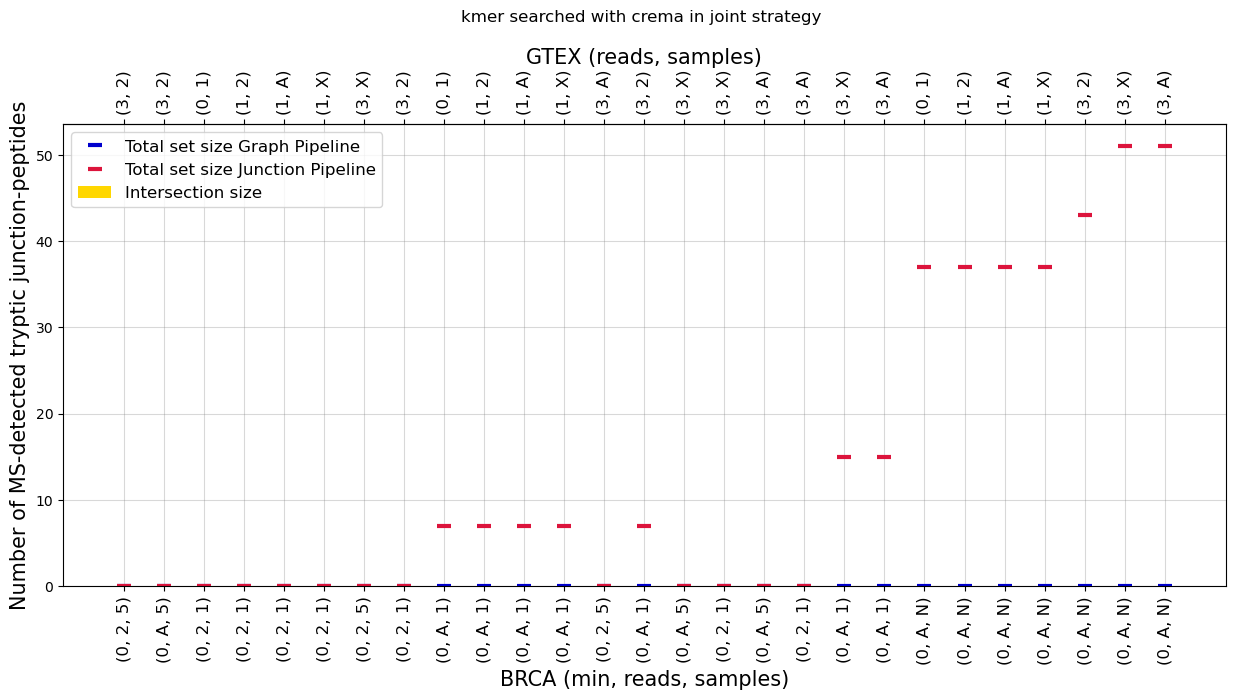

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


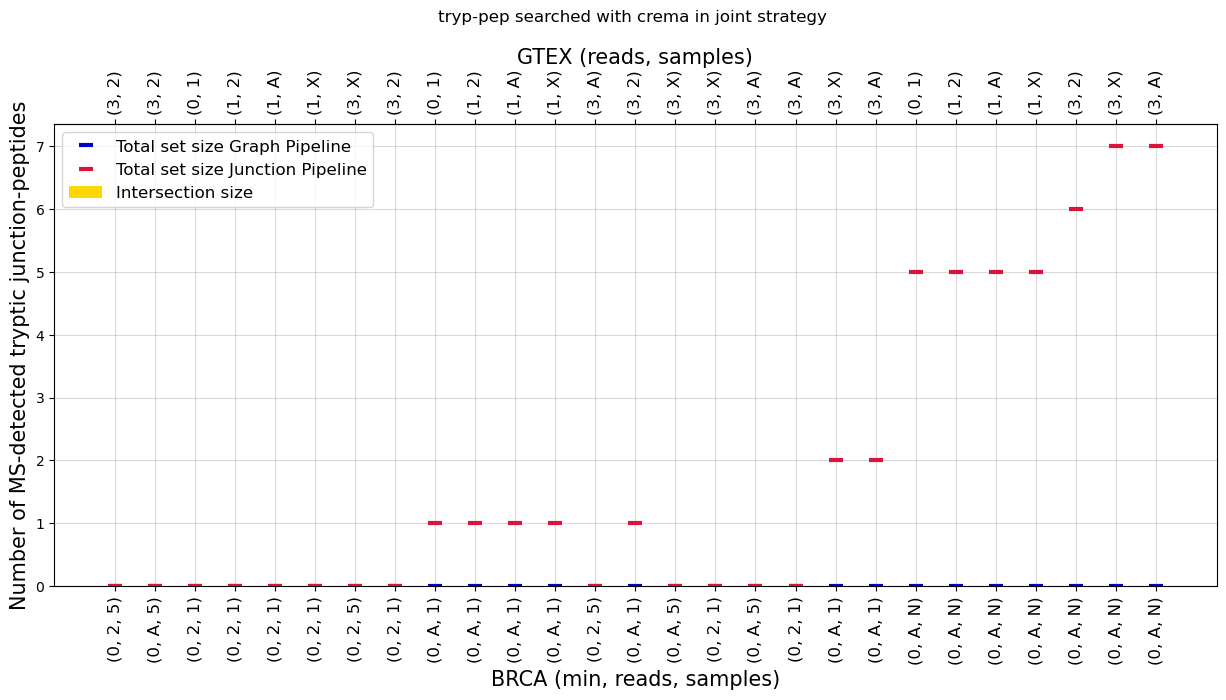

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_pool.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


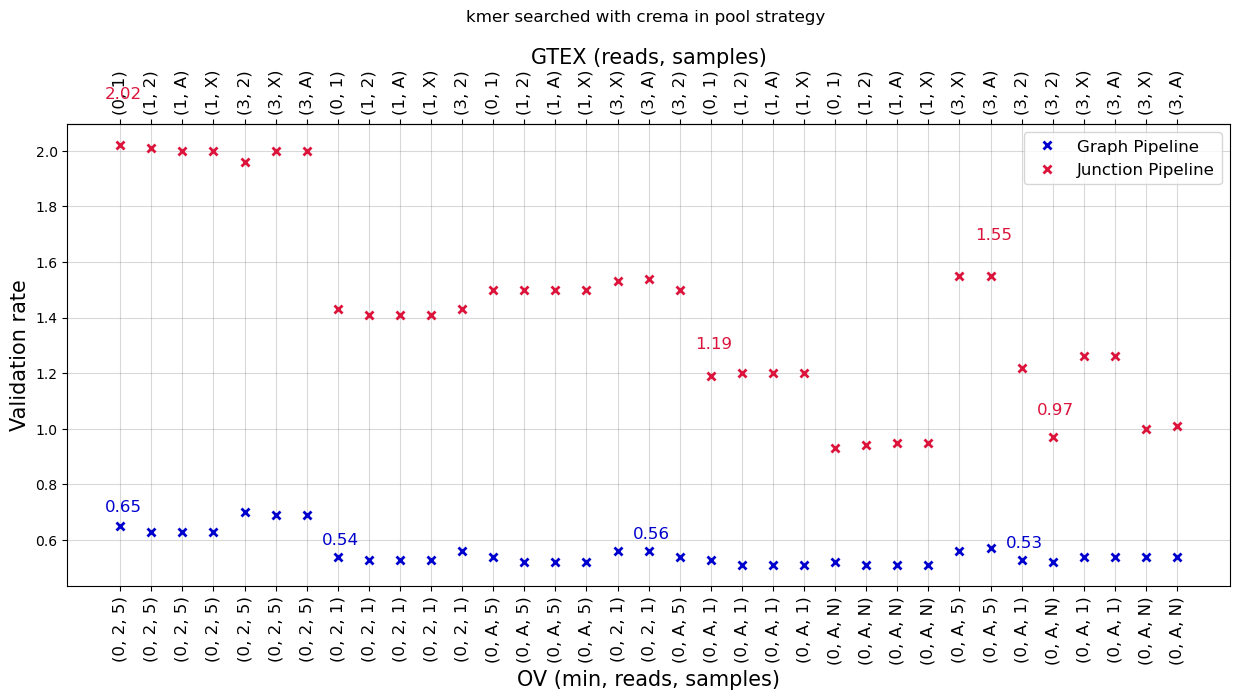

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_pool.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


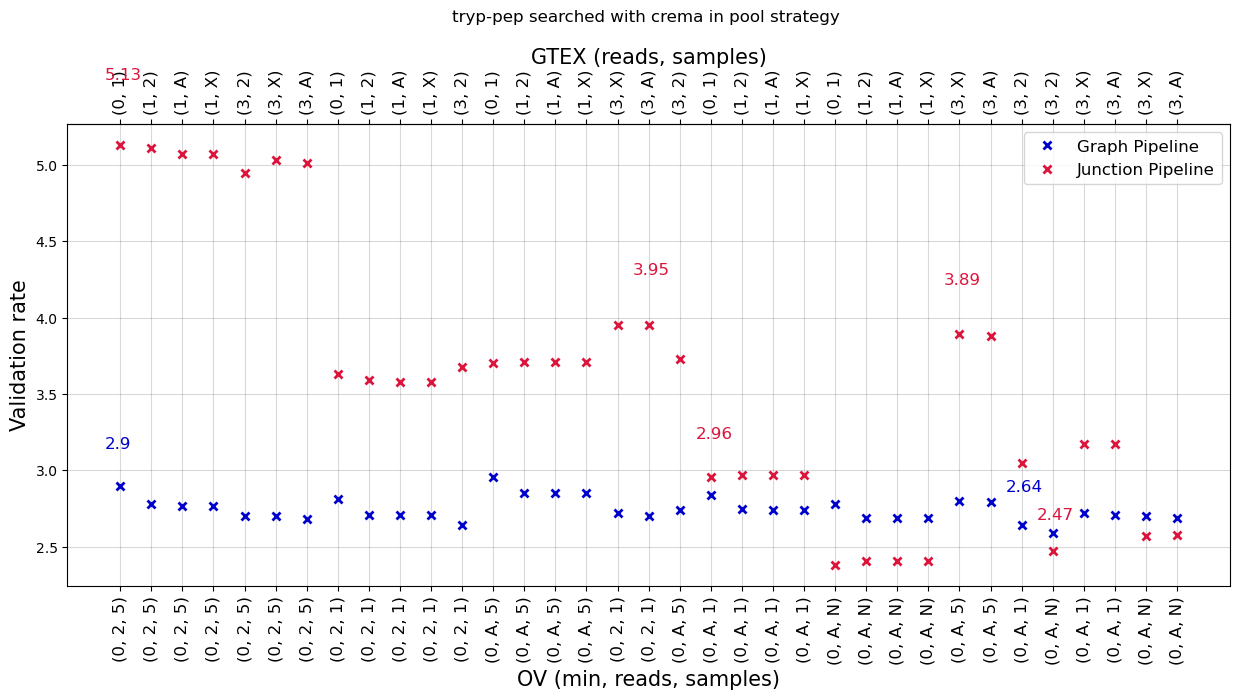

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_pool.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


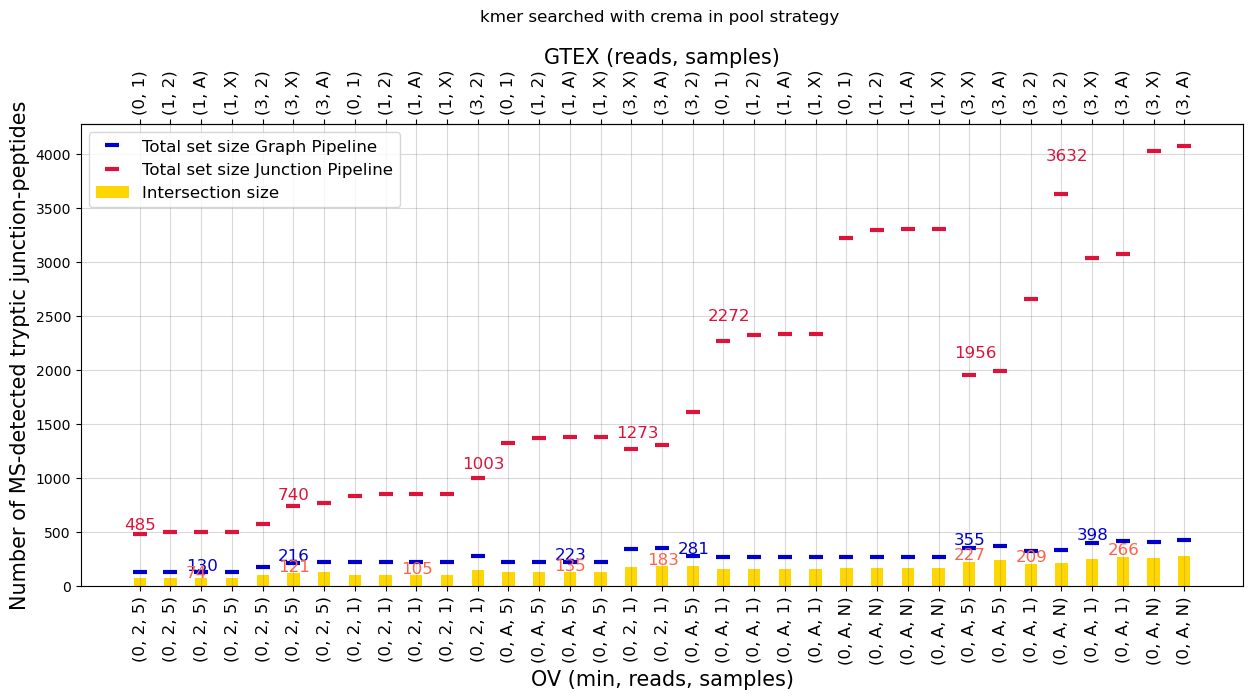

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_pool.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


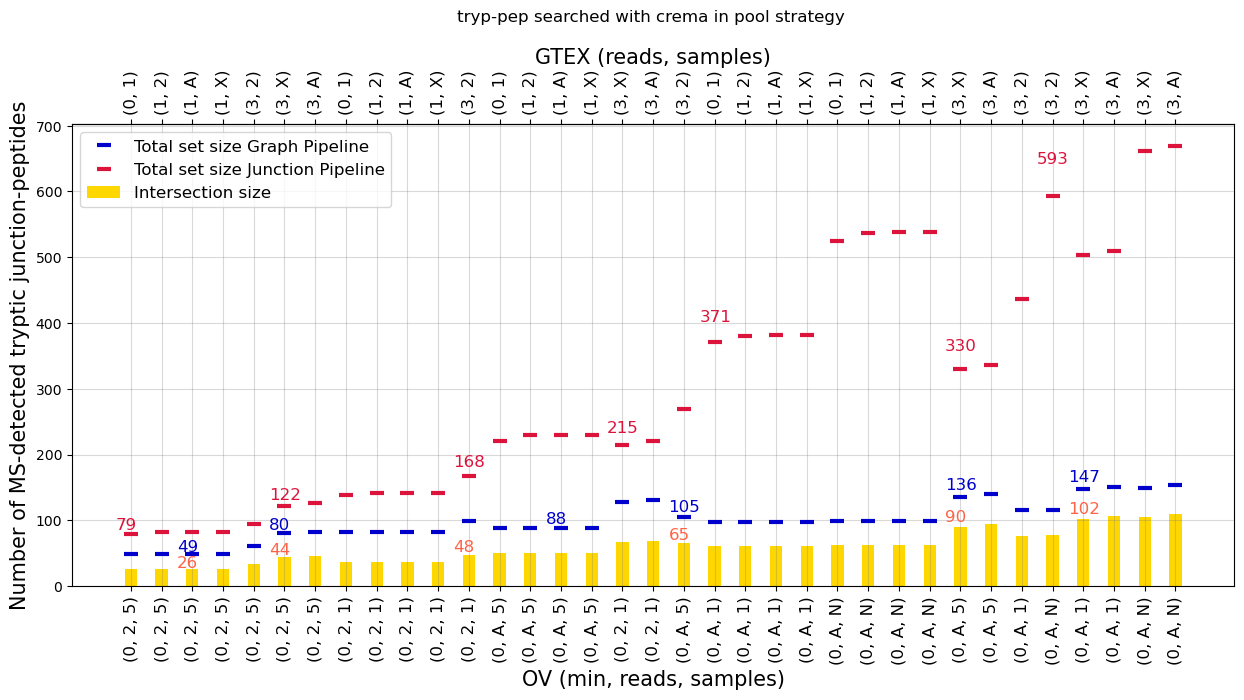

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_pool.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


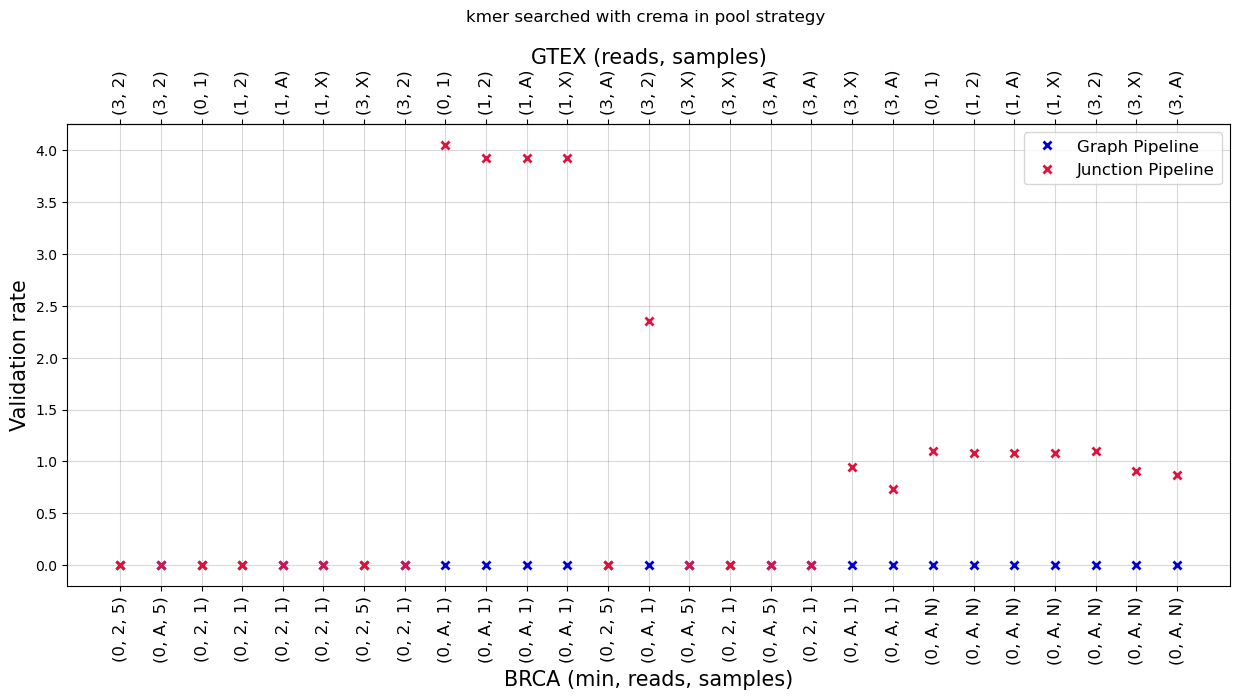

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_pool.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


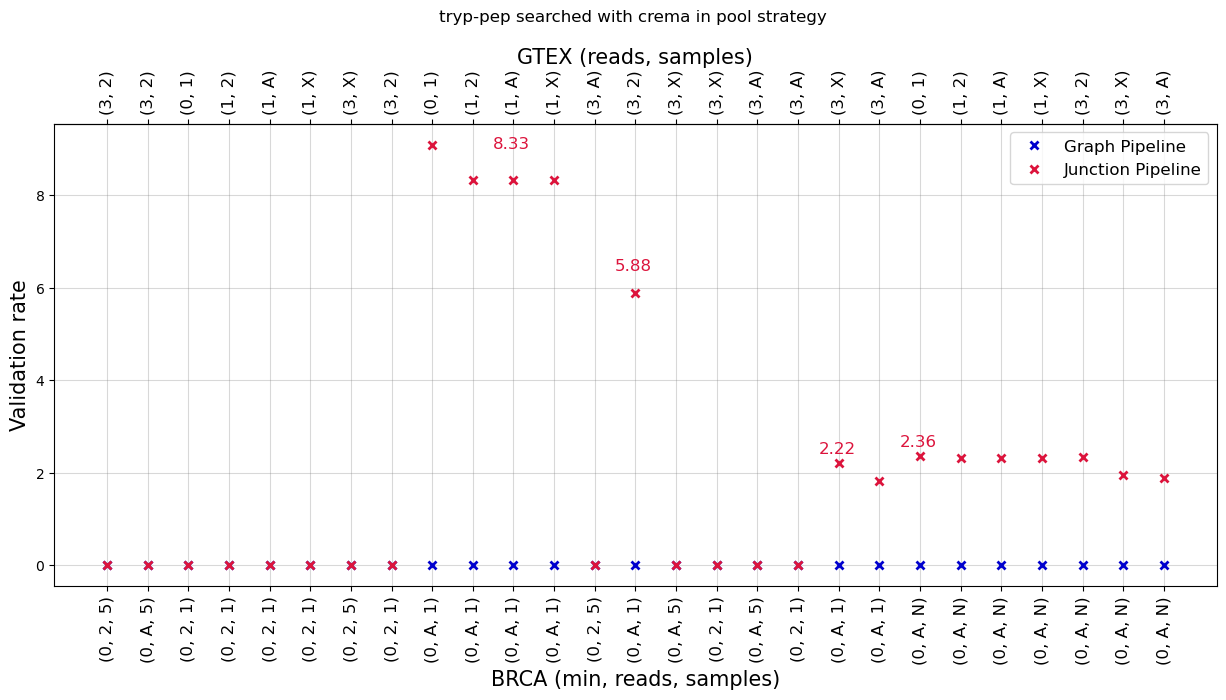

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_pool.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


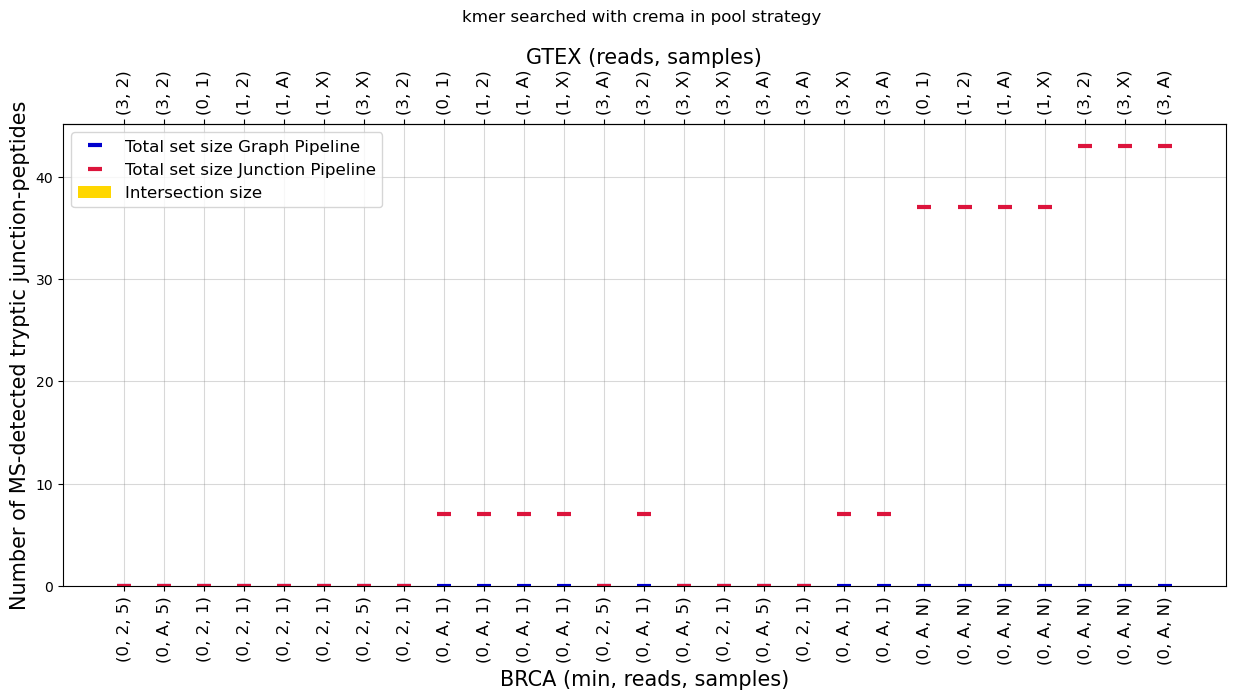

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_pool.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


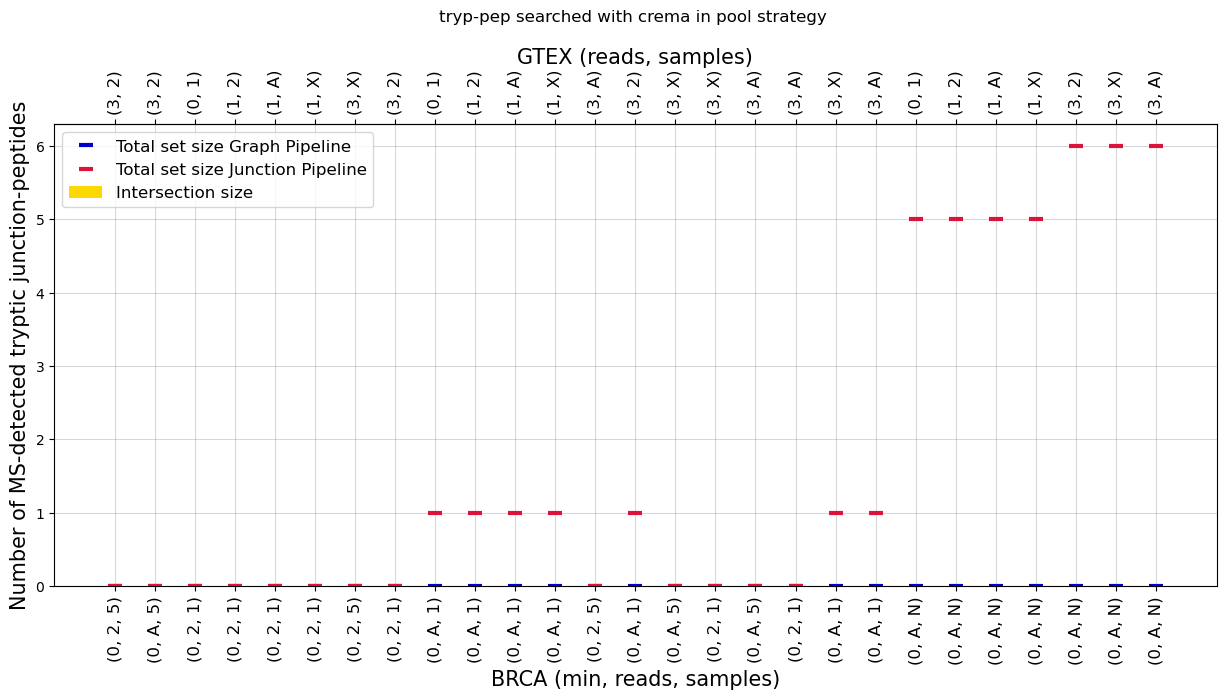

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_single.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


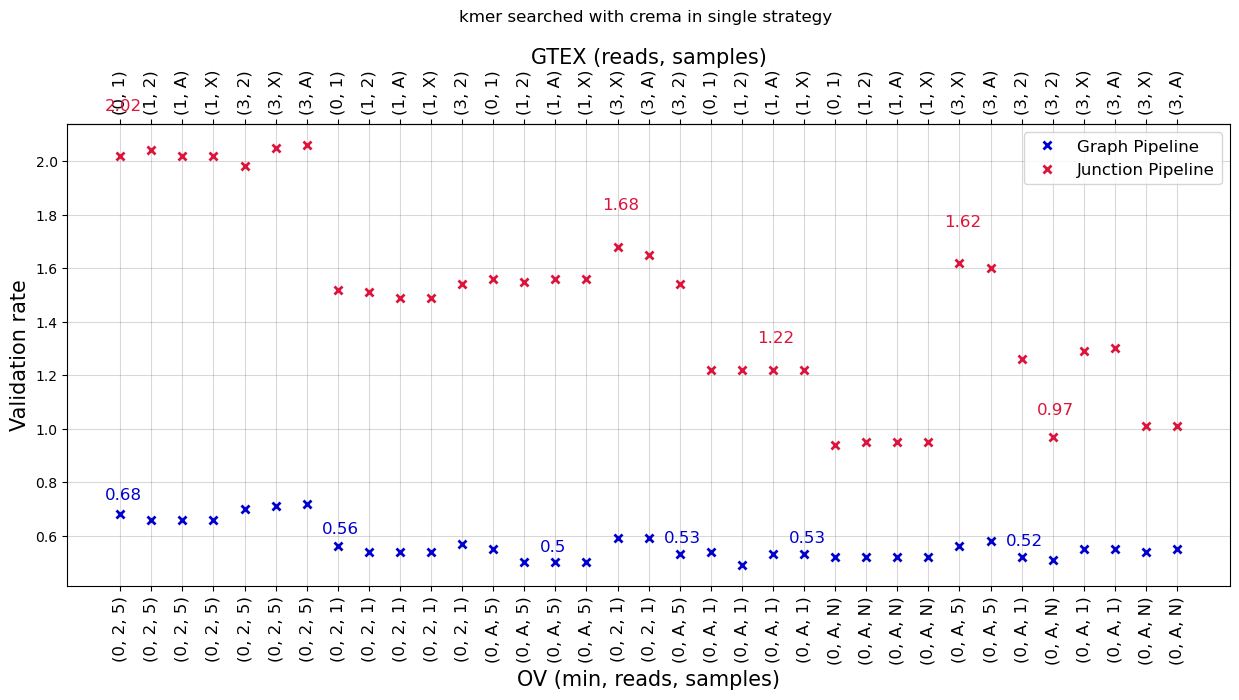

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_single.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


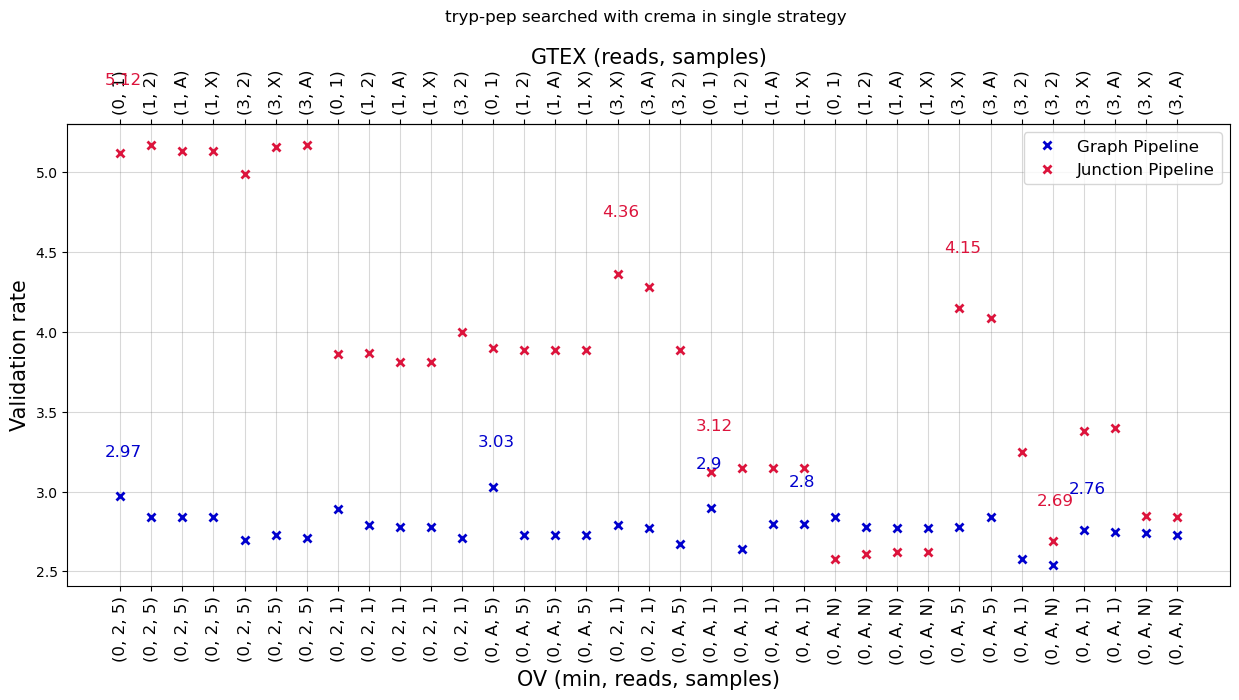

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_single.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


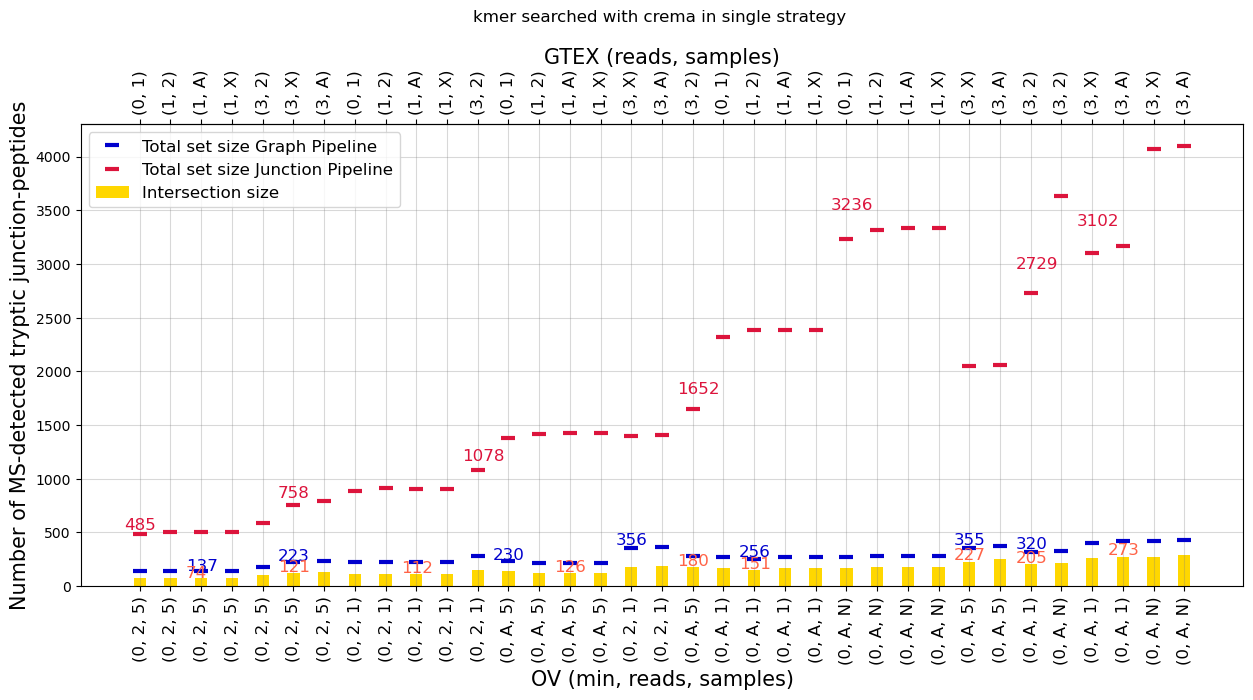

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_single.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


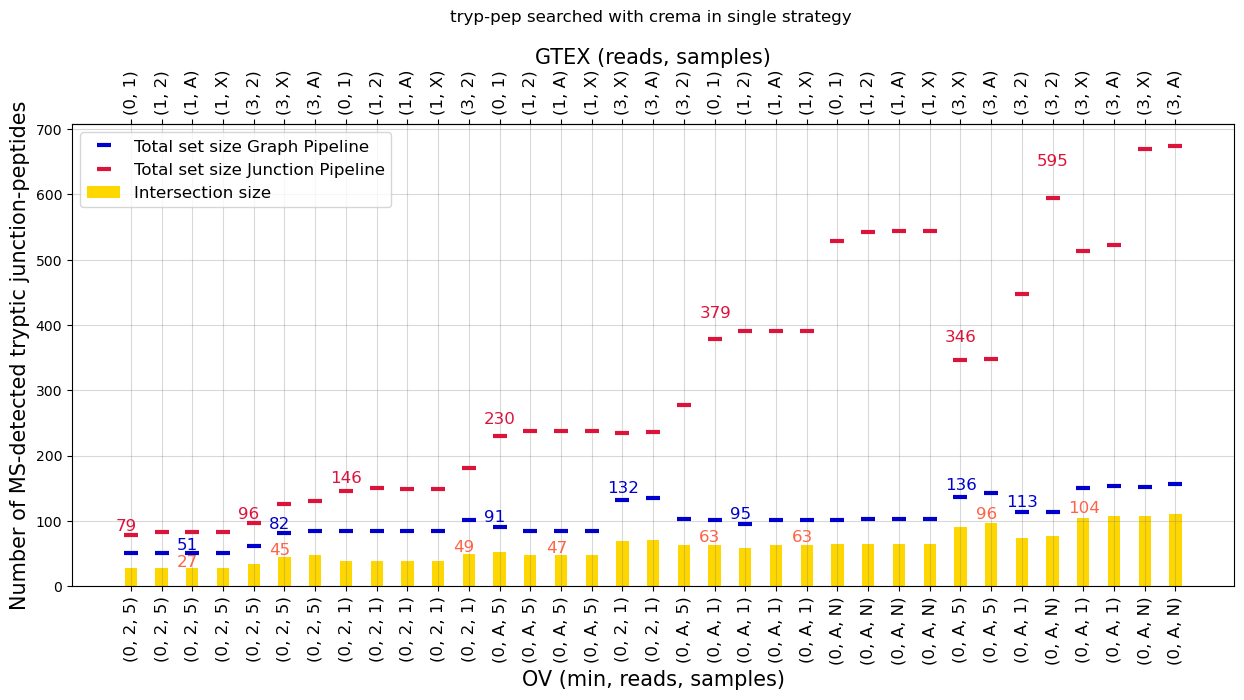

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_single.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


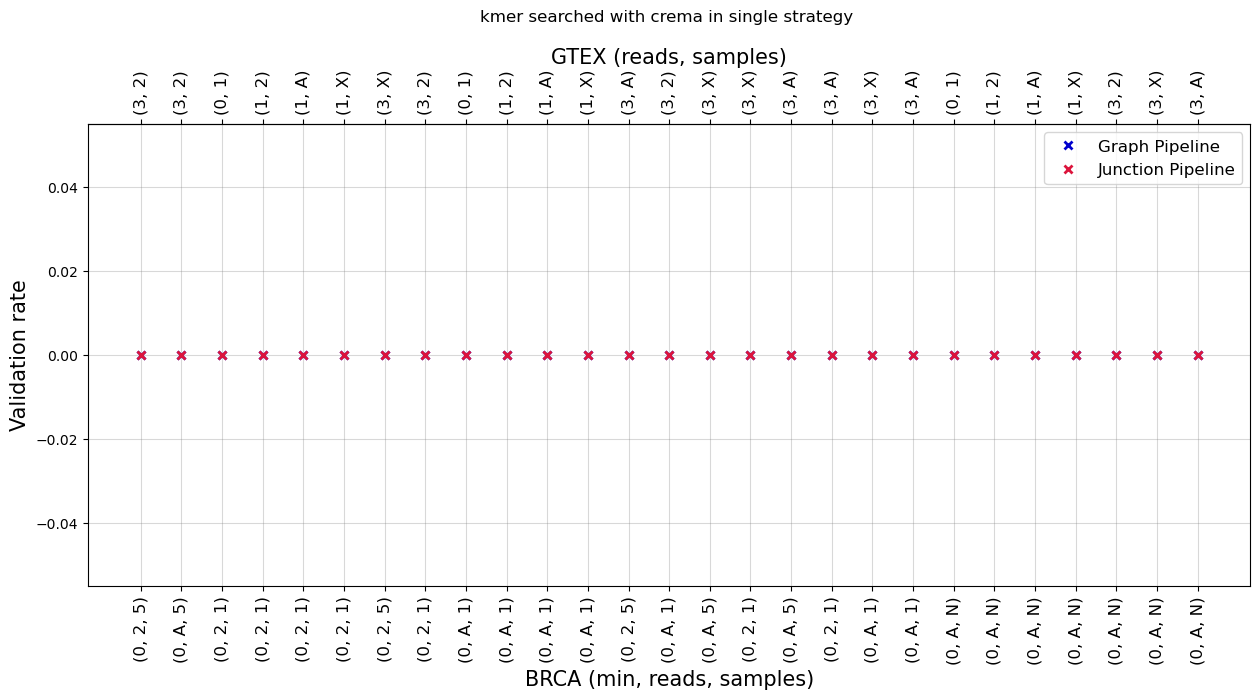

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_single.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


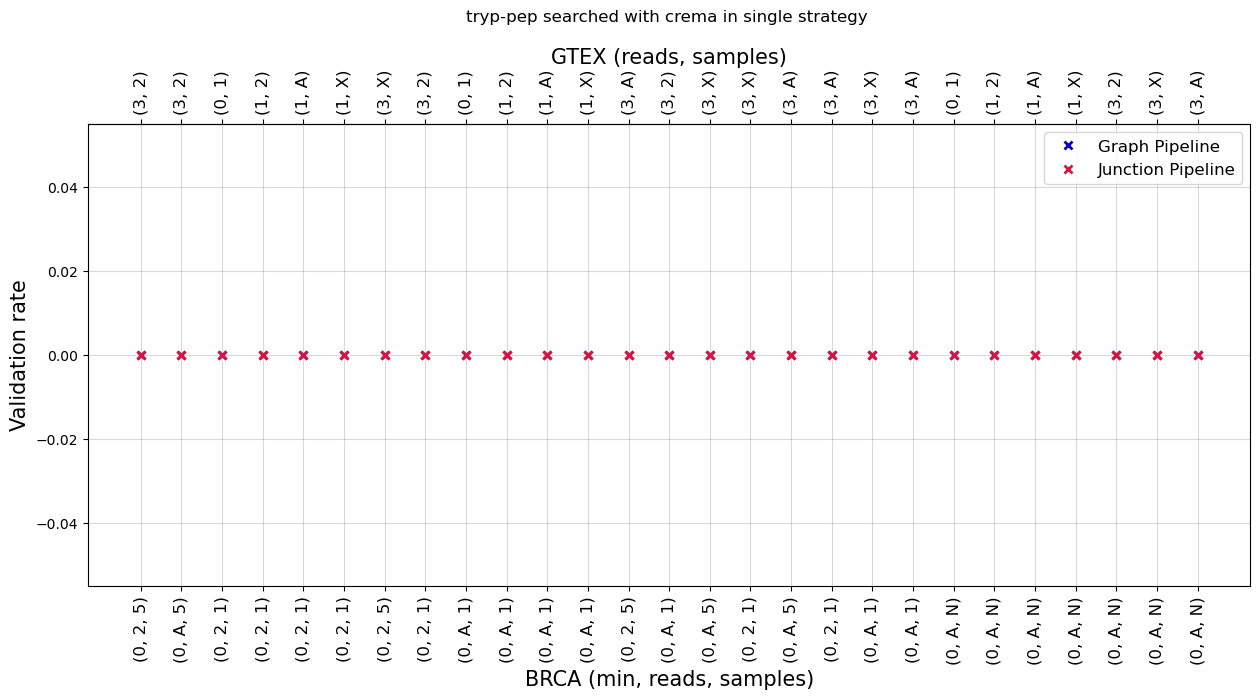

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_single.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


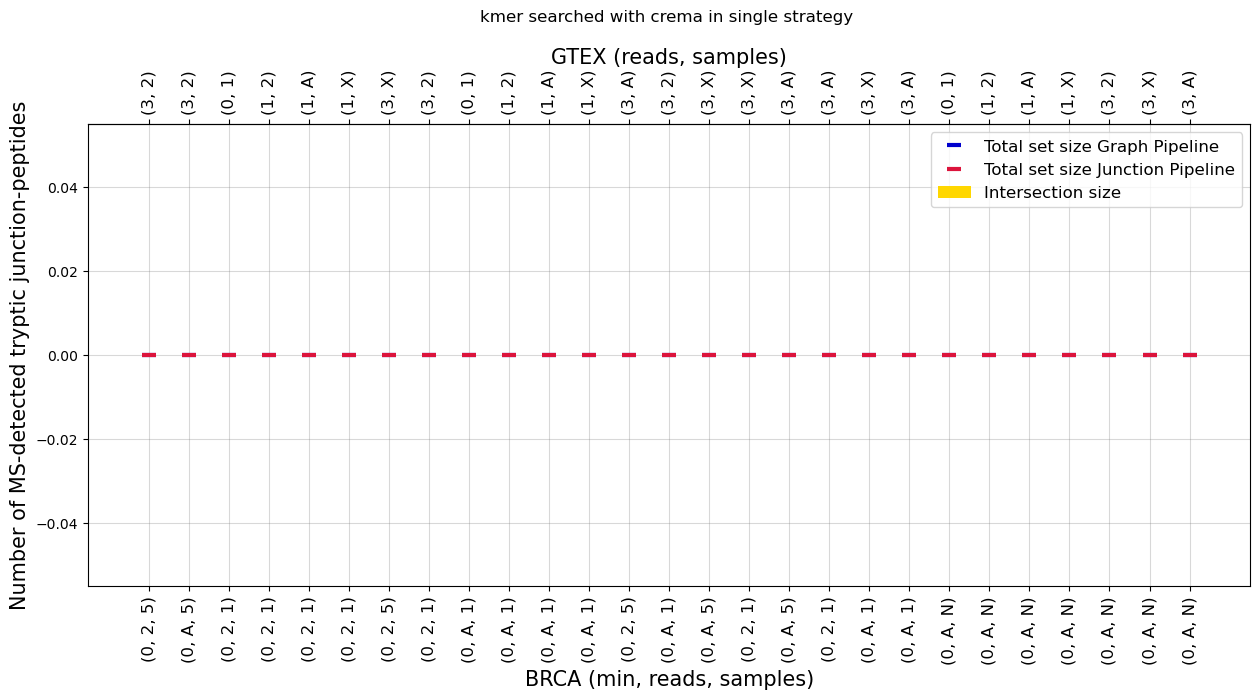

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_single.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crema_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


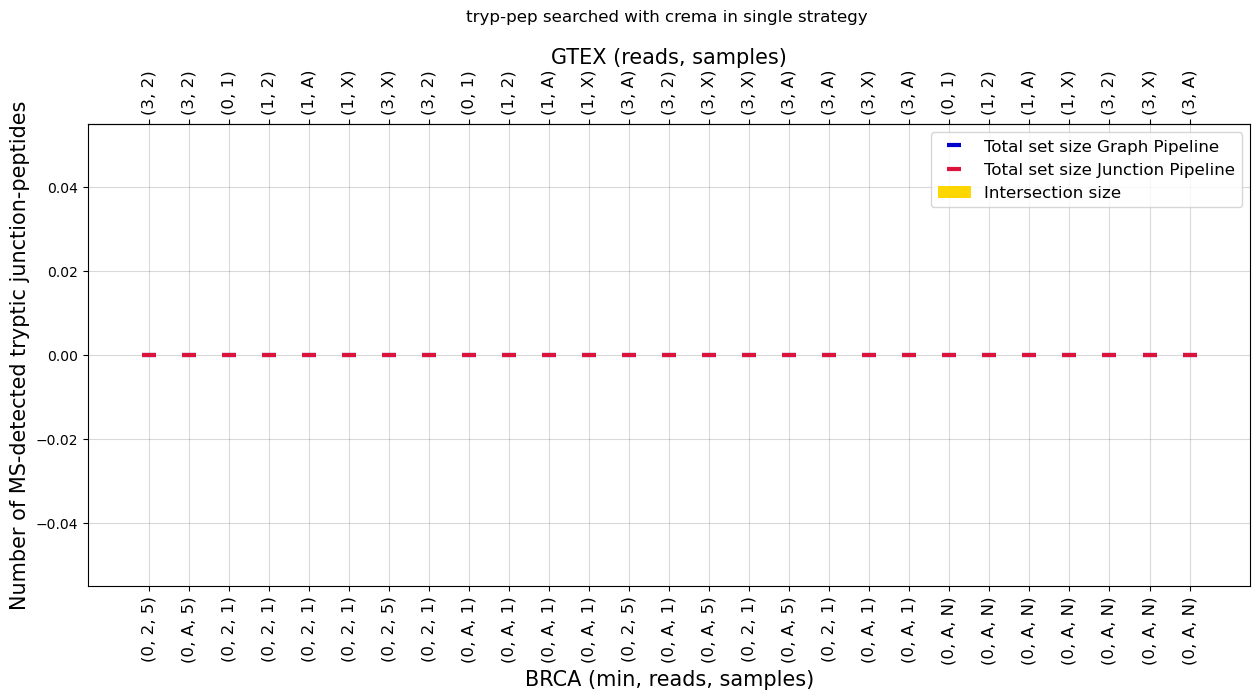

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_joint.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


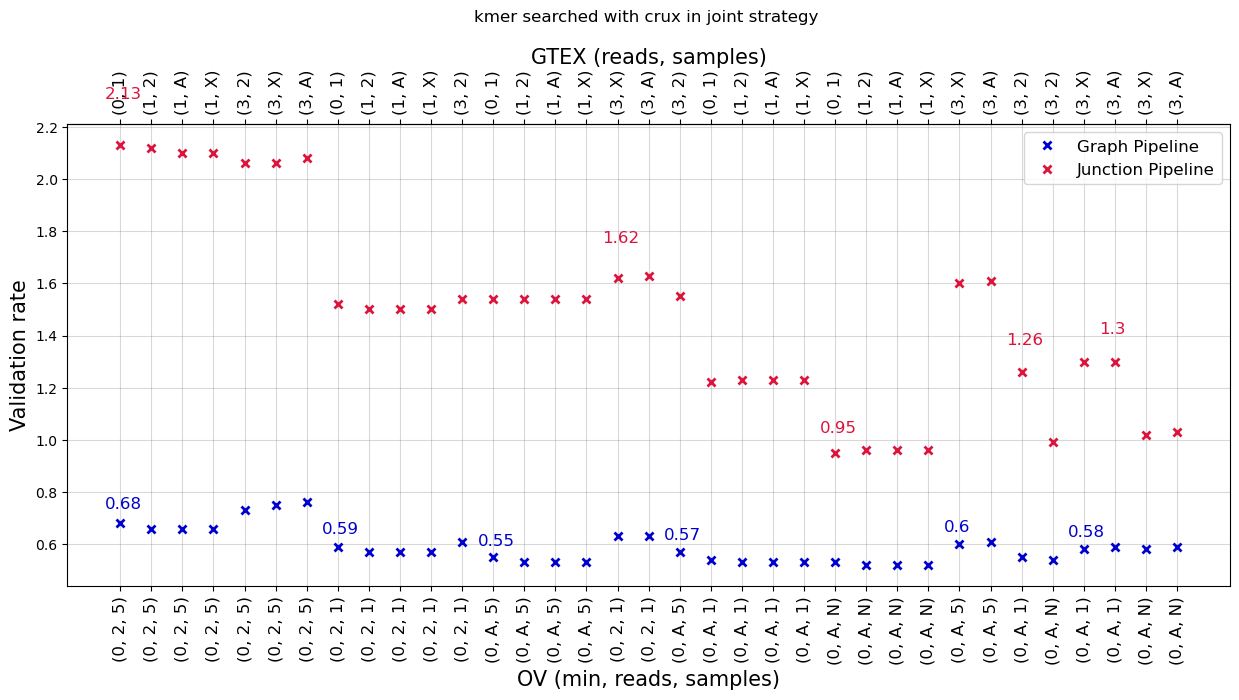

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_joint.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


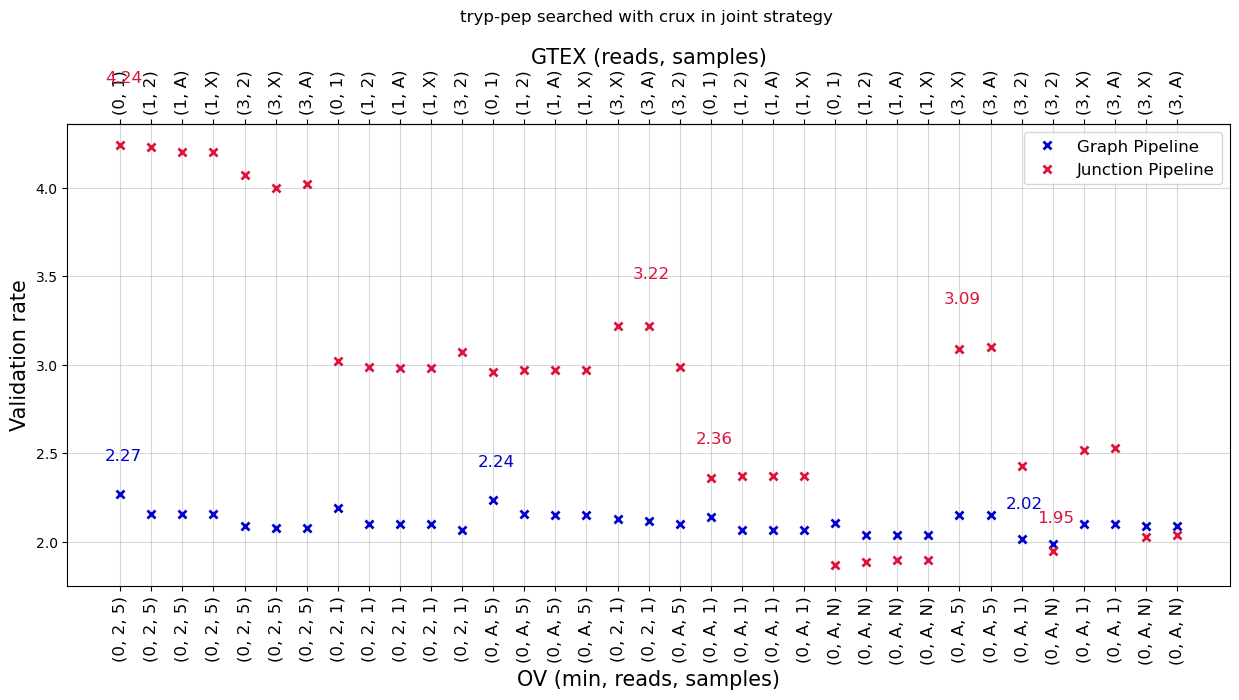

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_joint.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


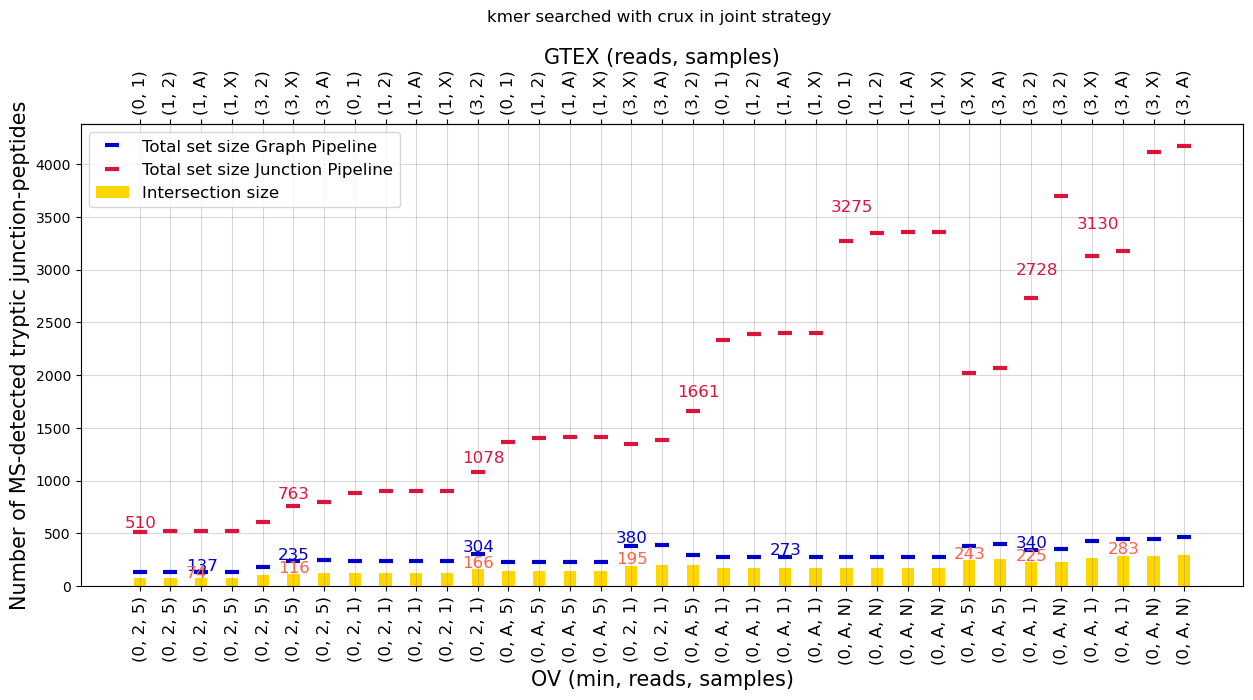

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_joint.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


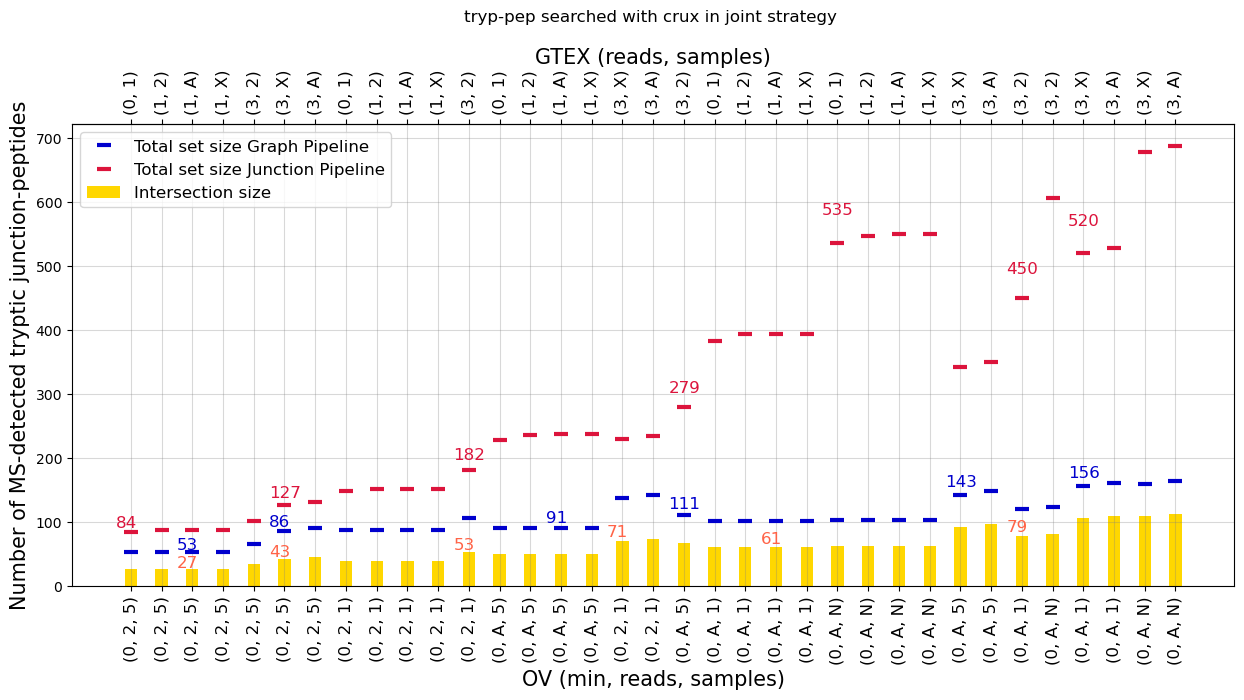

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_joint.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


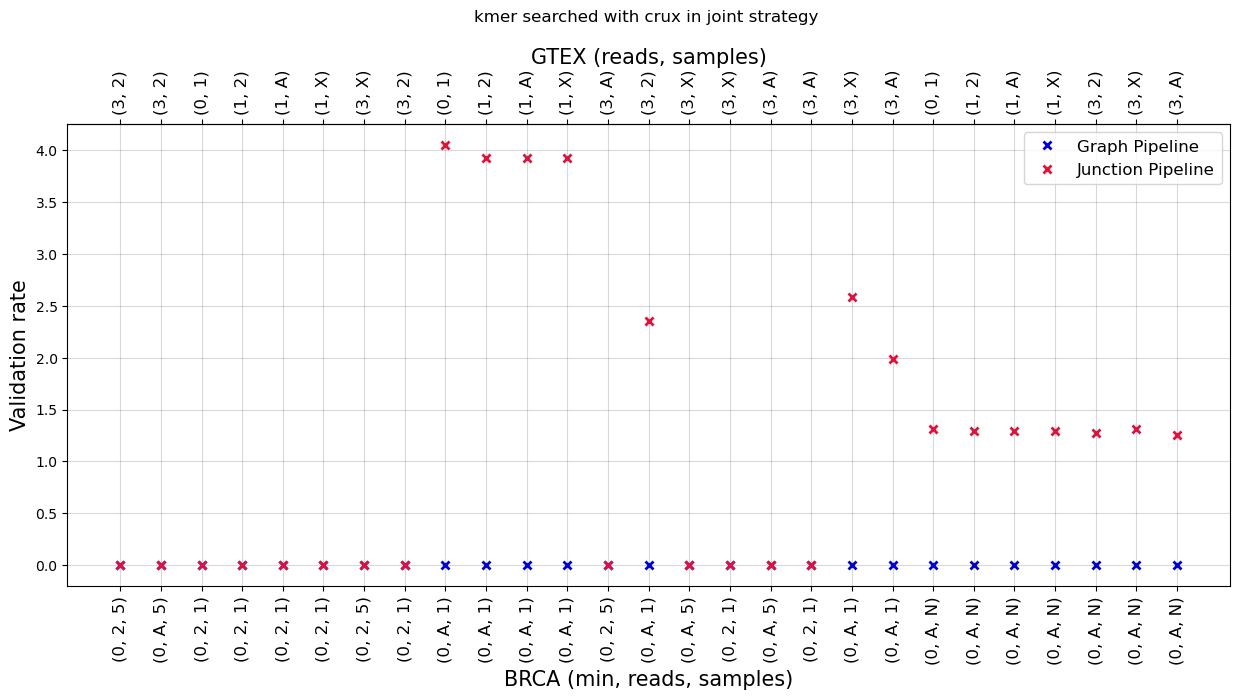

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_joint.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


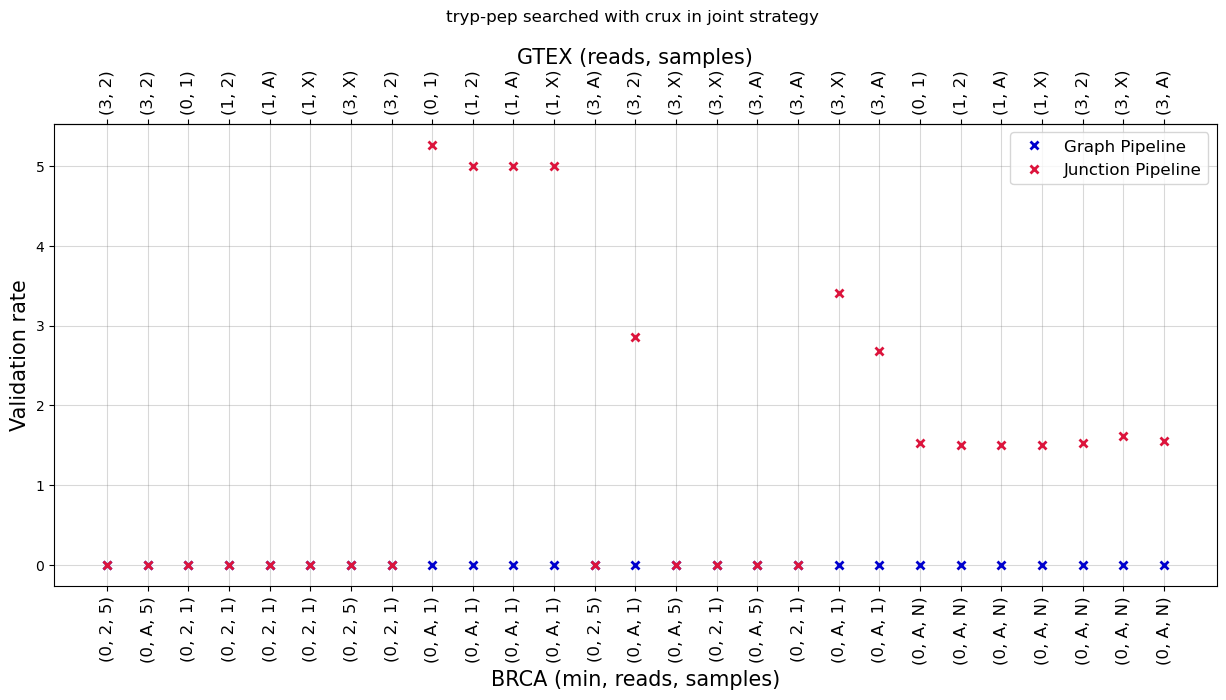

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_joint.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


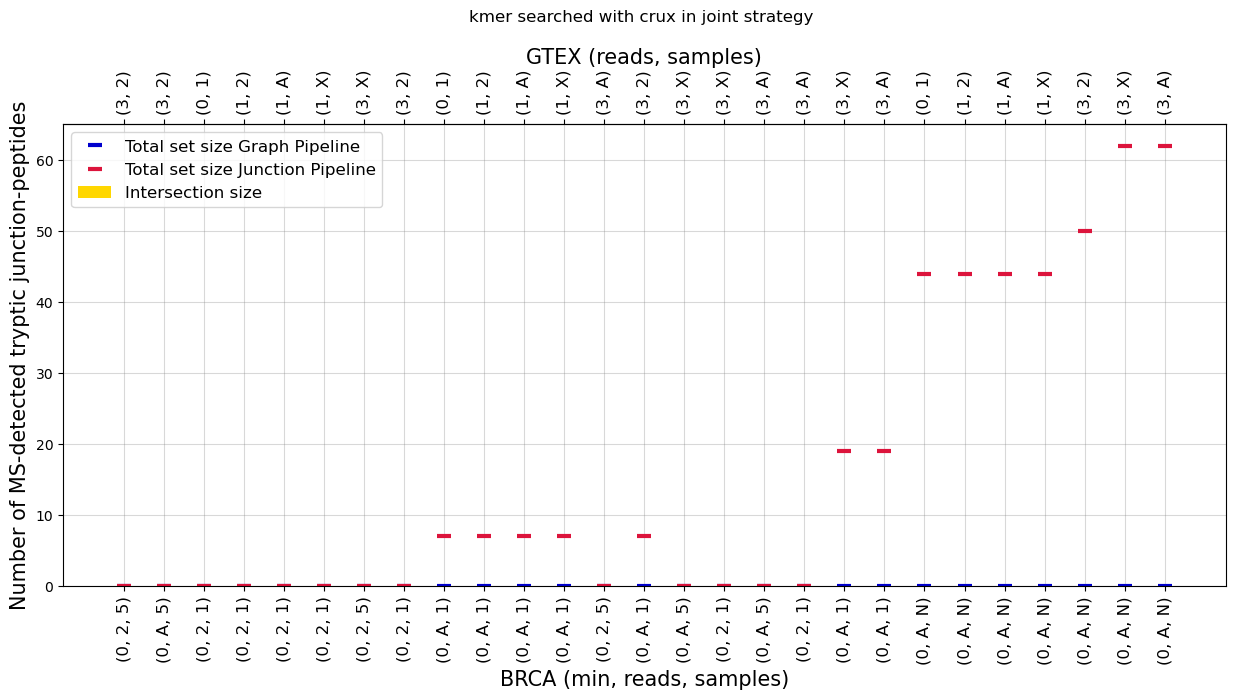

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_joint.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


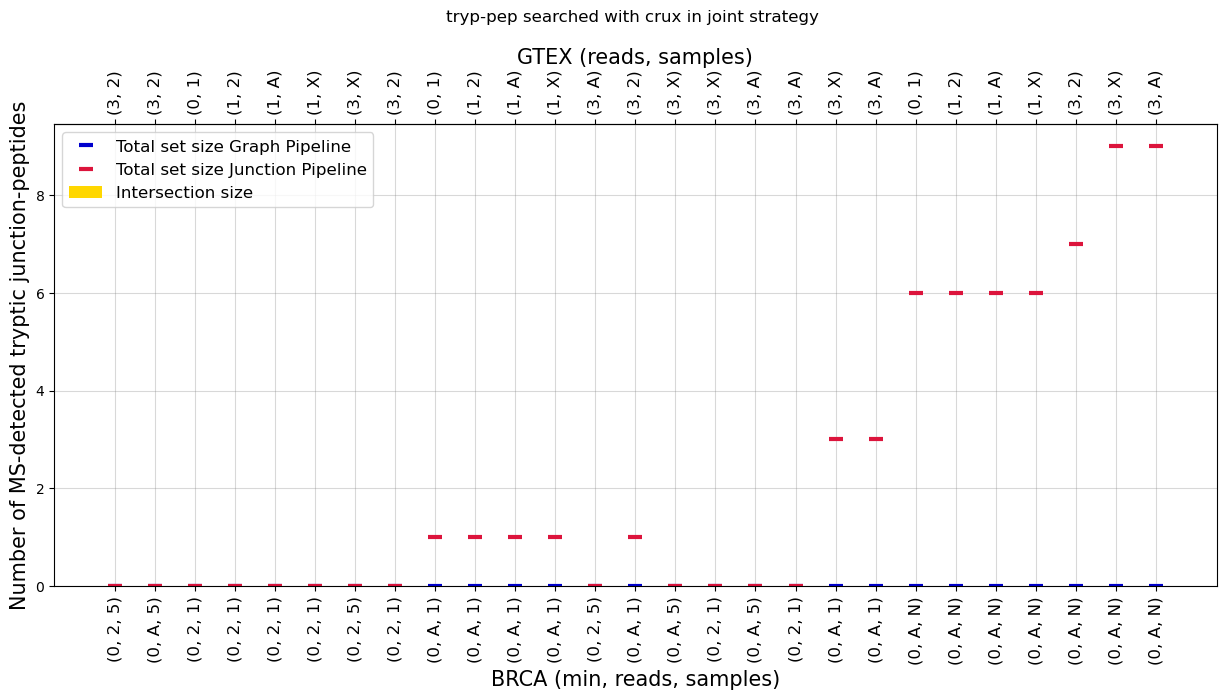

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_pool.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


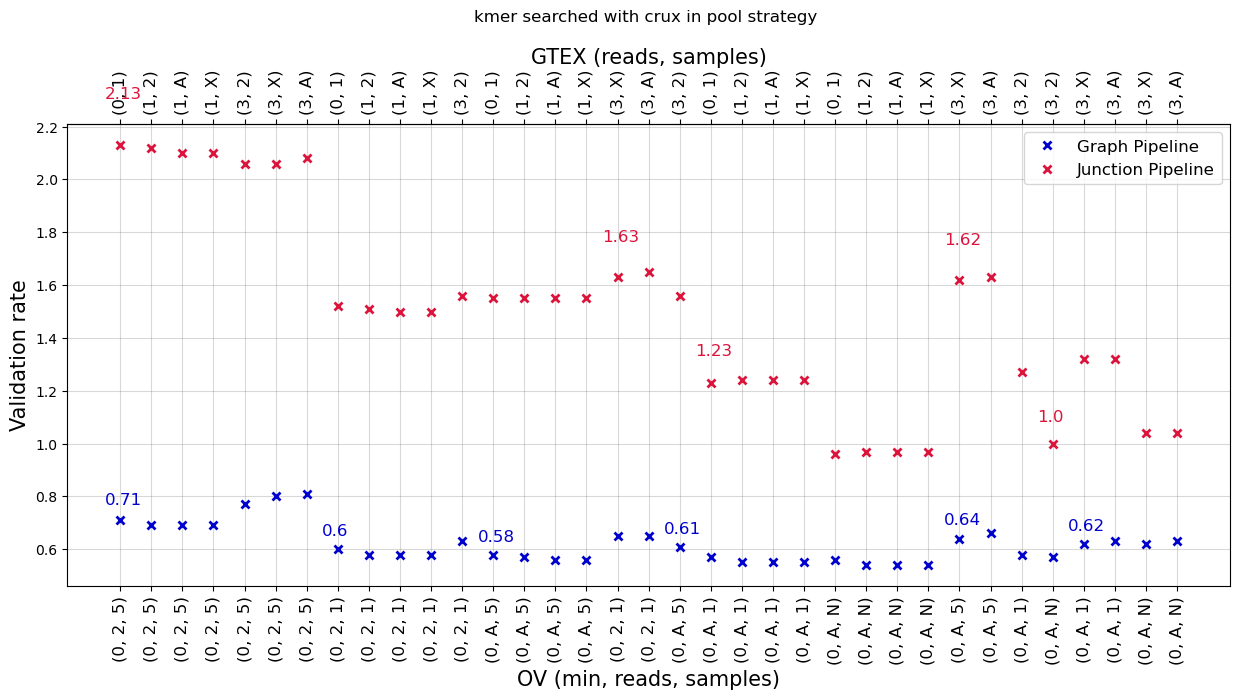

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_pool.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


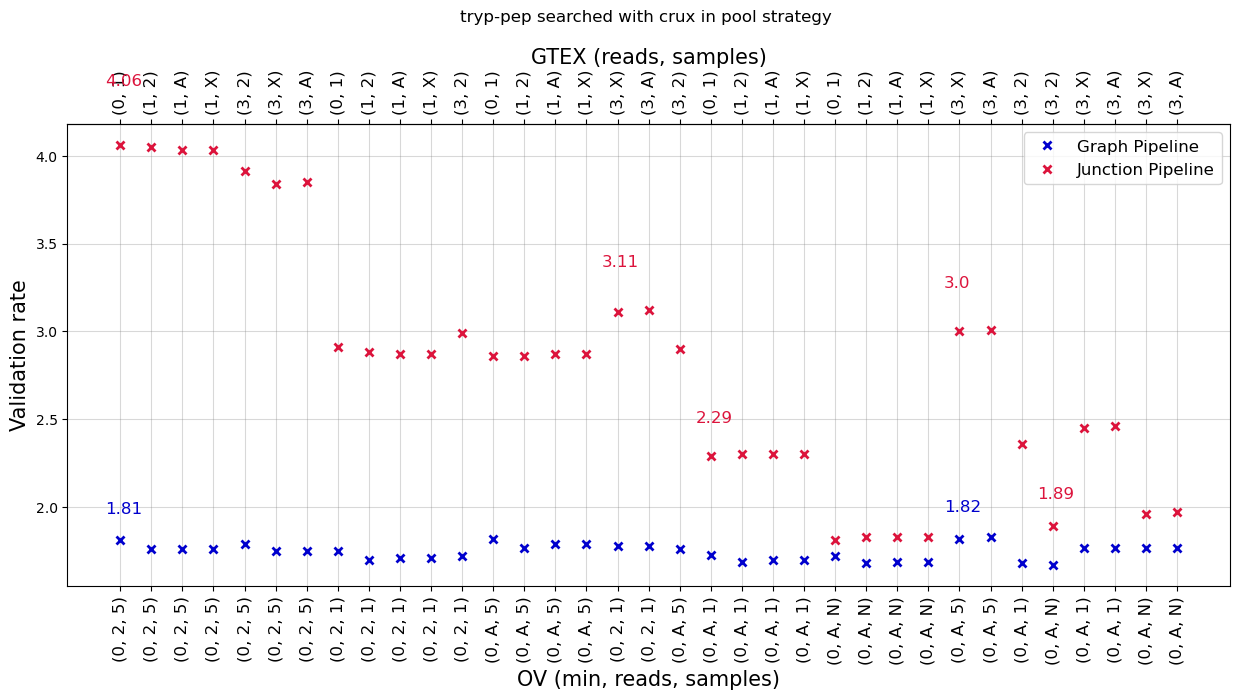

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_pool.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


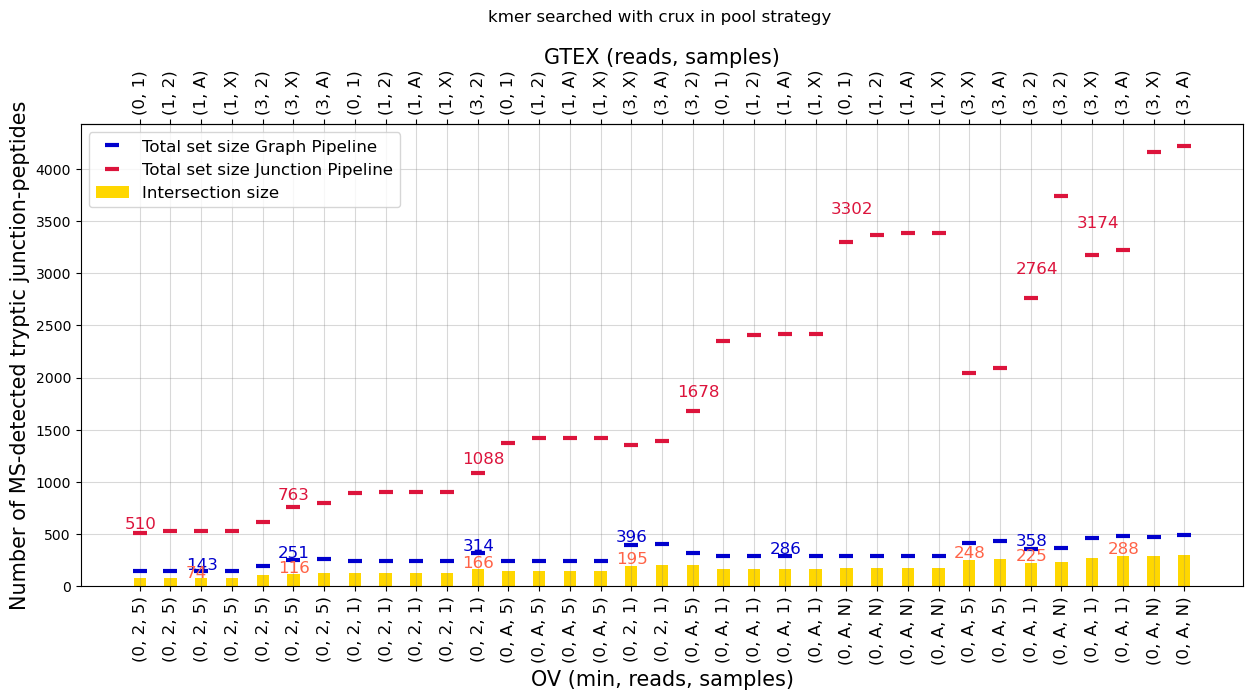

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_pool.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


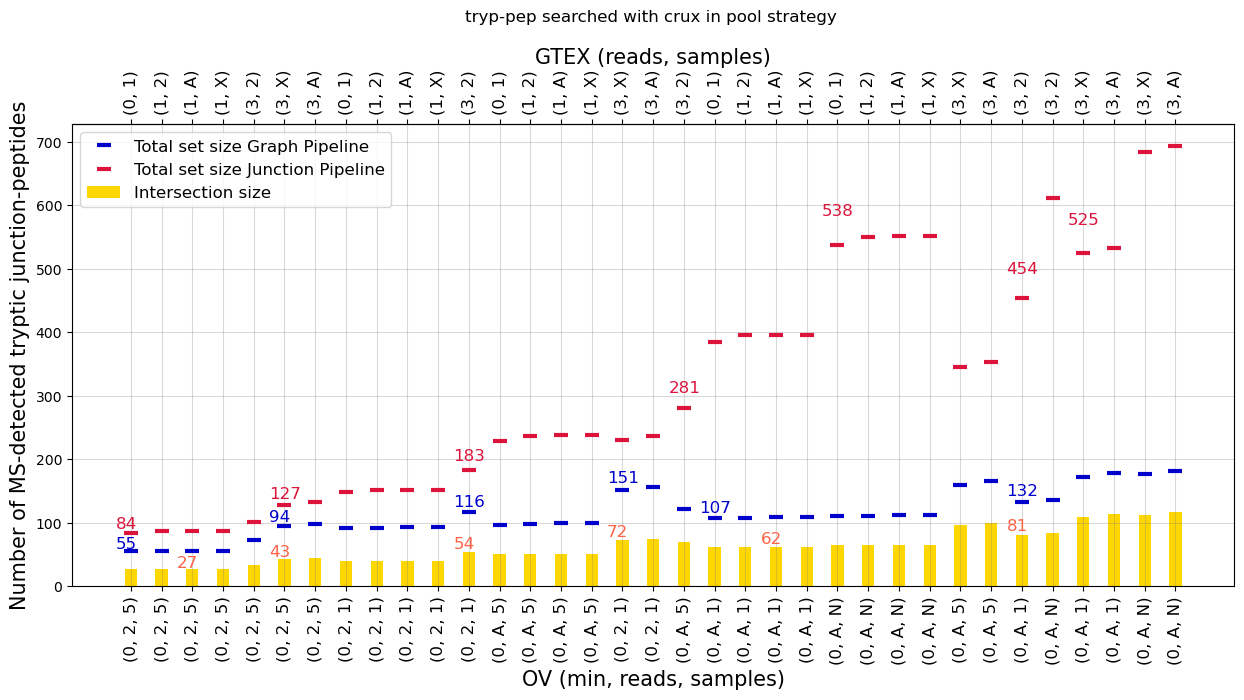

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_pool.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


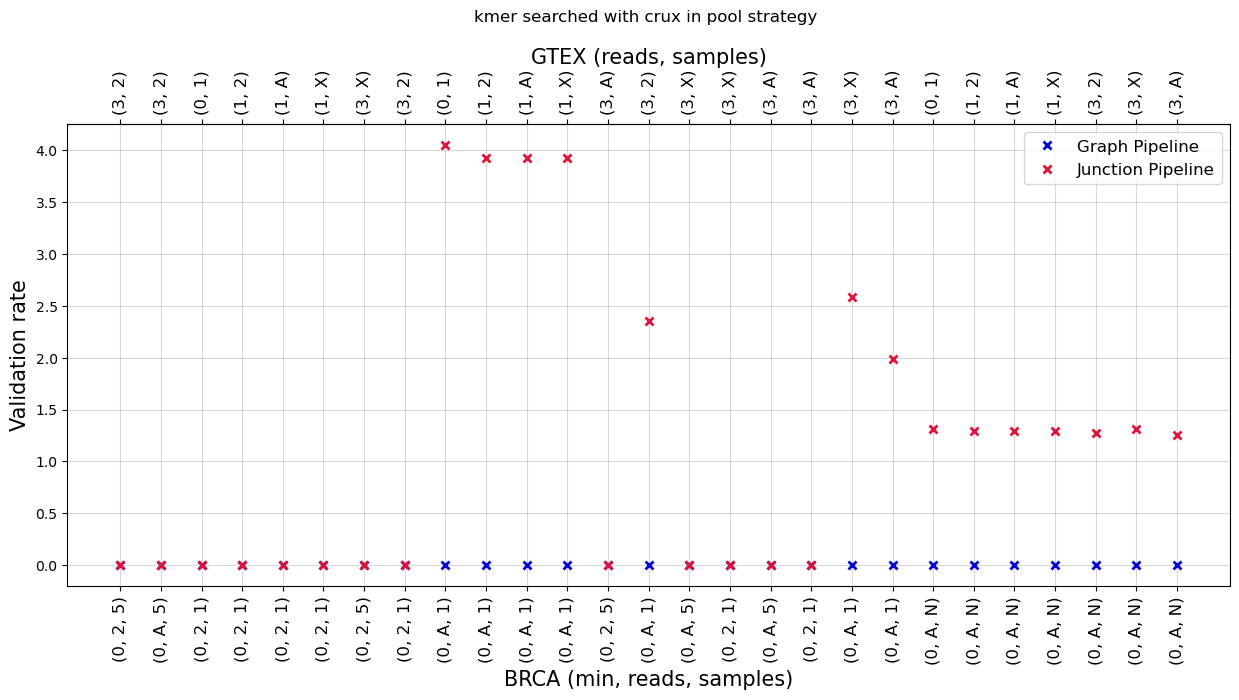

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_pool.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


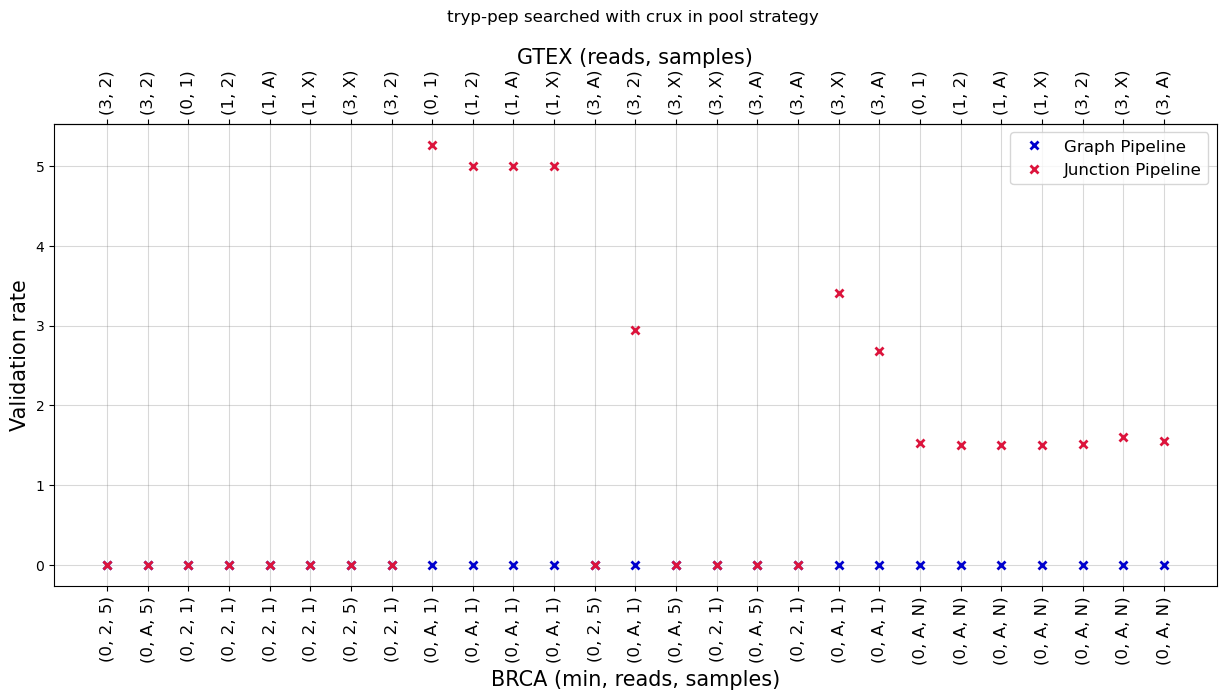

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_pool.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


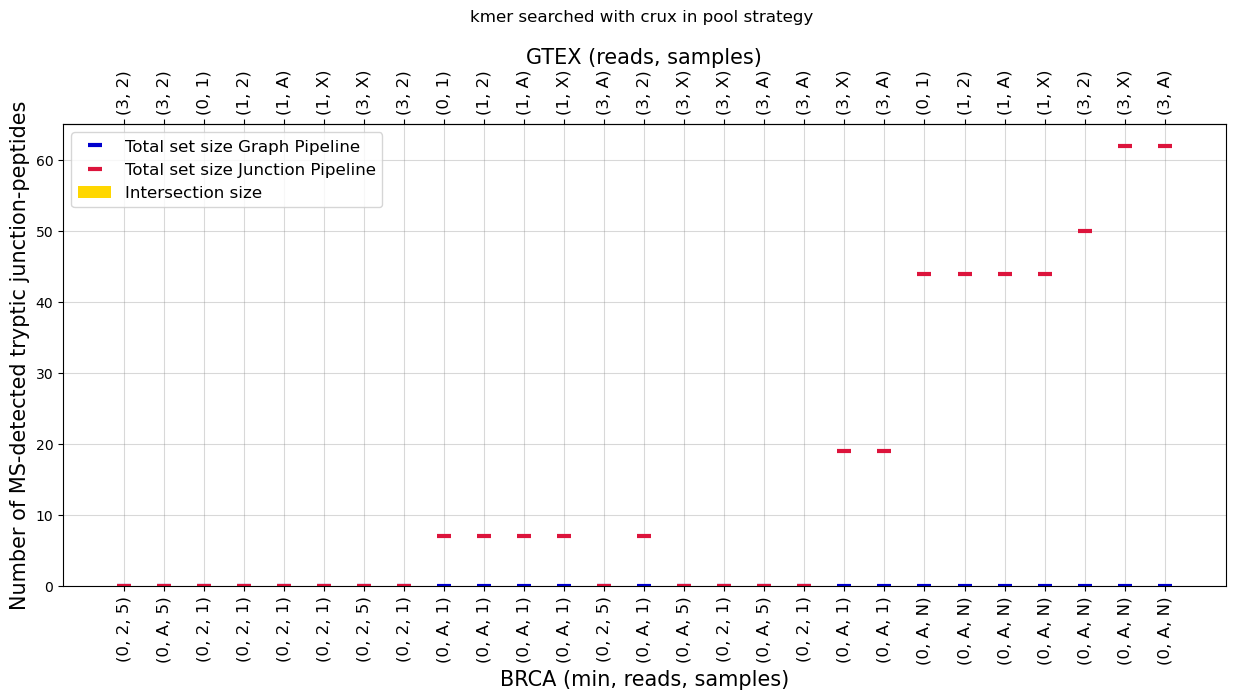

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_pool.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_pool.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


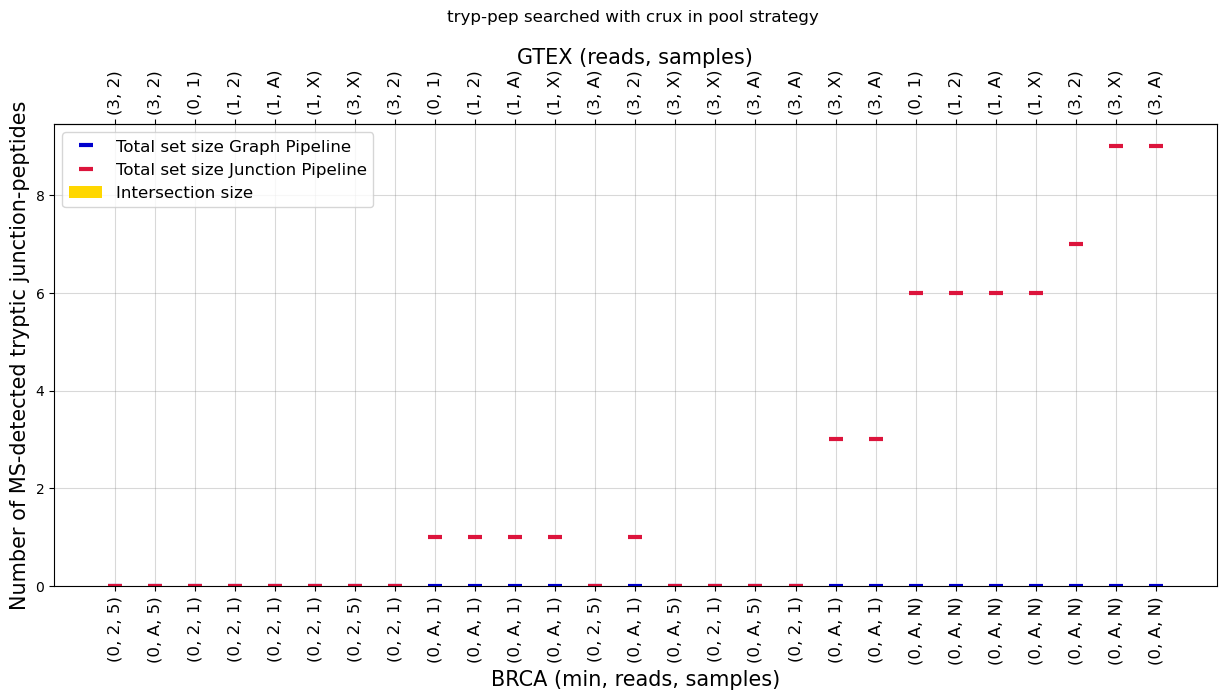

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_single.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_kmer_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


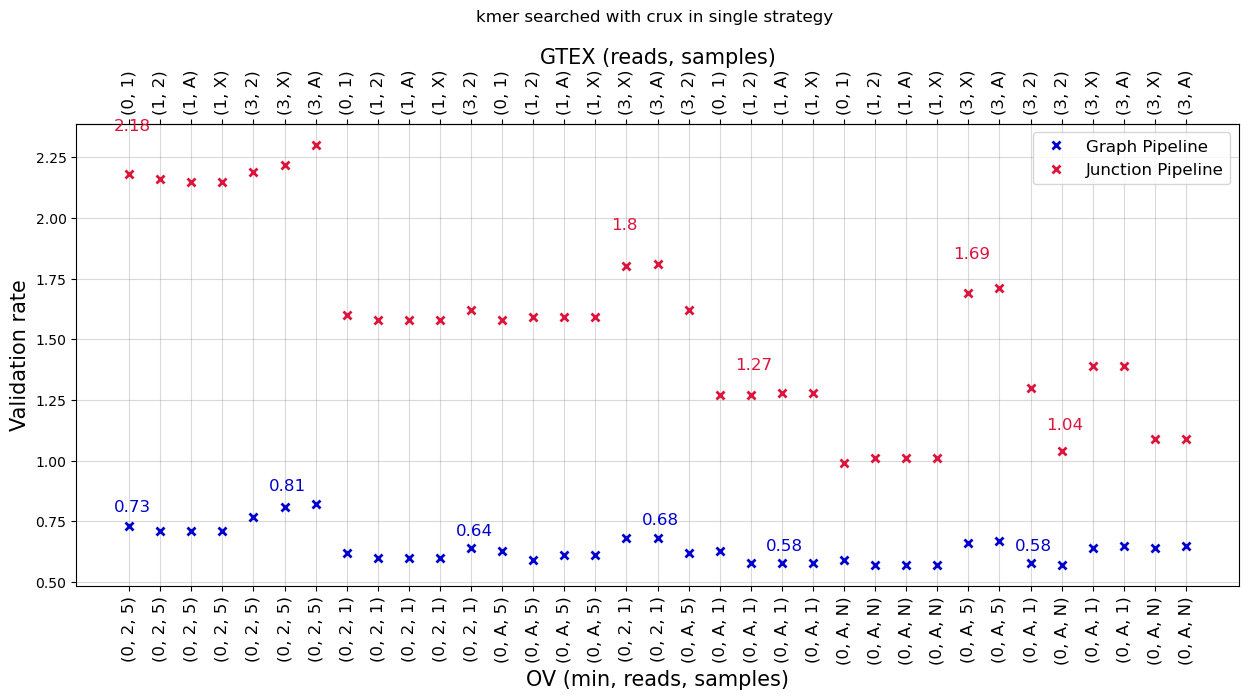

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_single.tsv.gz
(70, 20)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_val_rate_tryp-pep_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


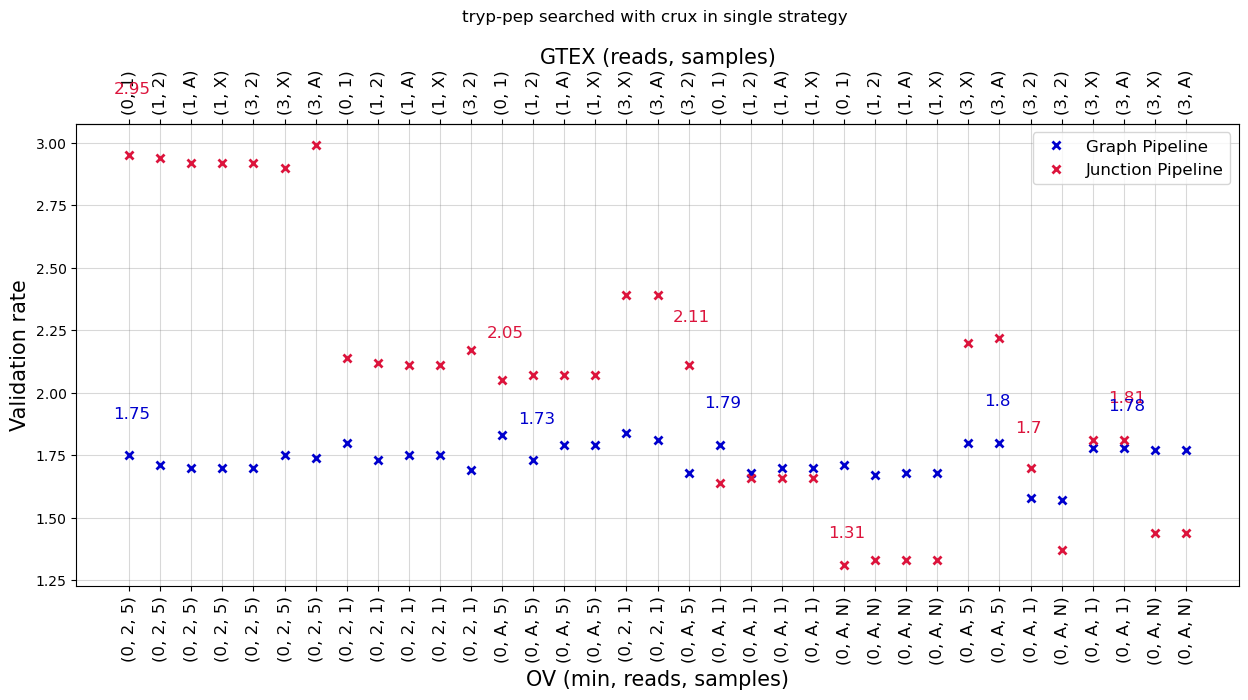

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_single.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_kmer_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


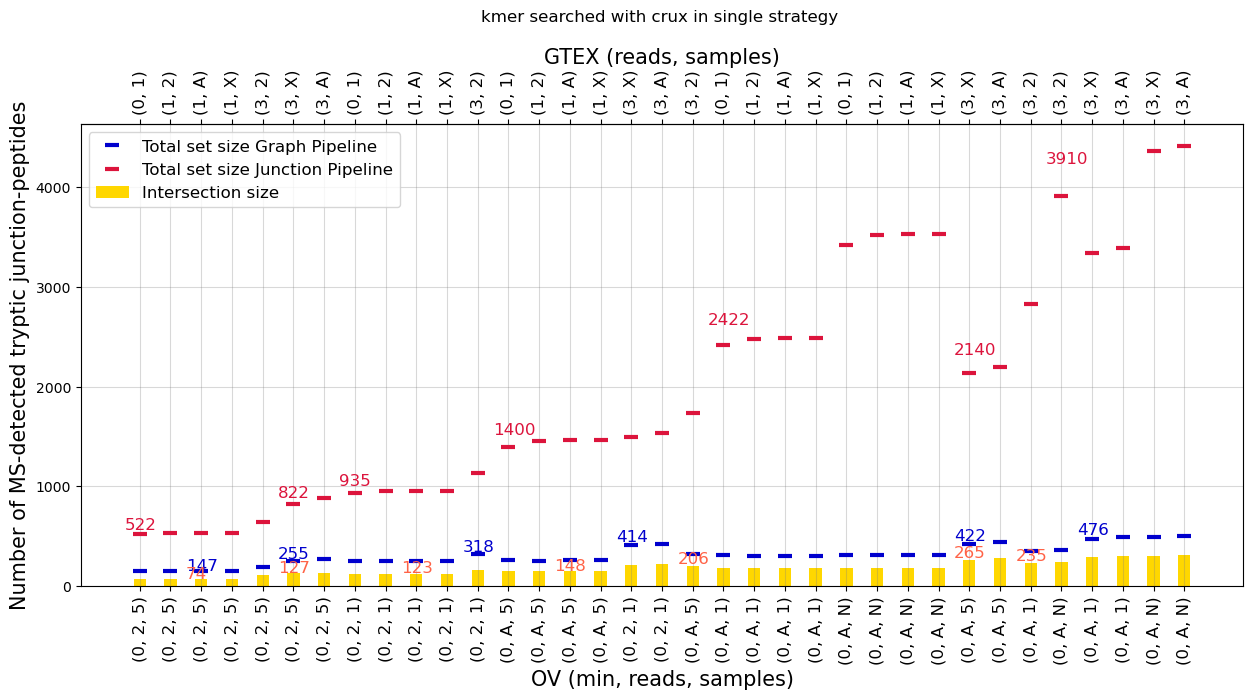

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_single.tsv.gz
(35, 23)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_tryp-pep_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


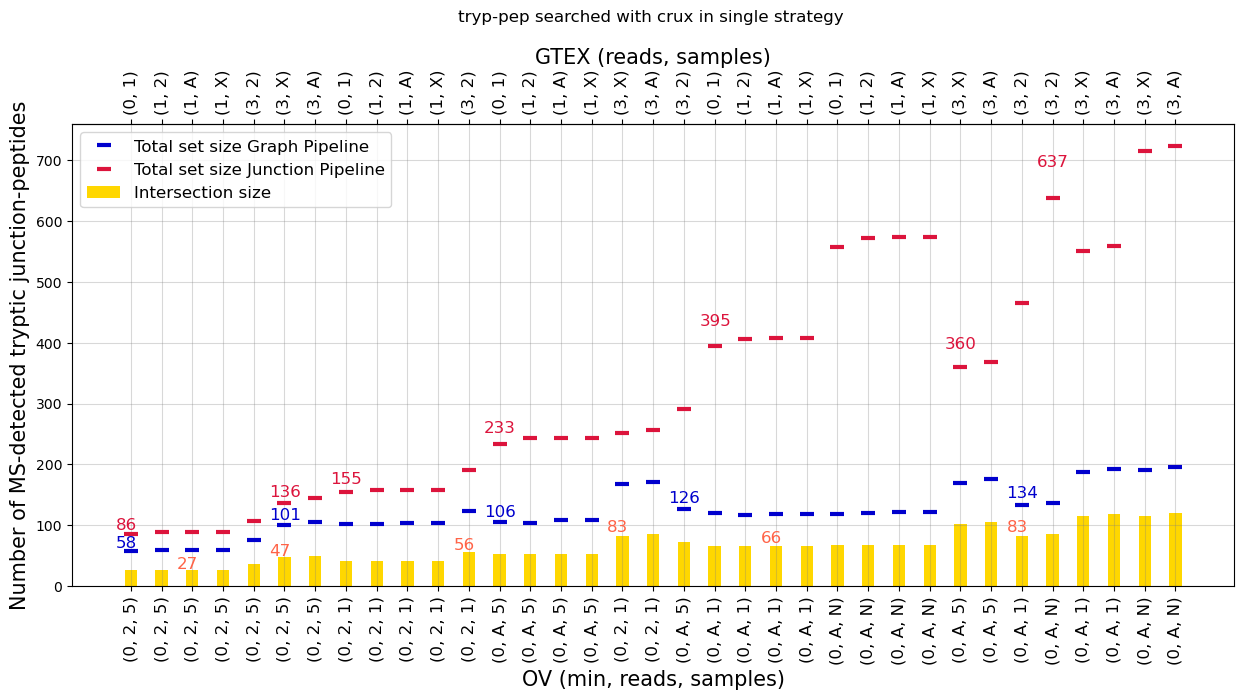

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crux_single.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_kmer_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


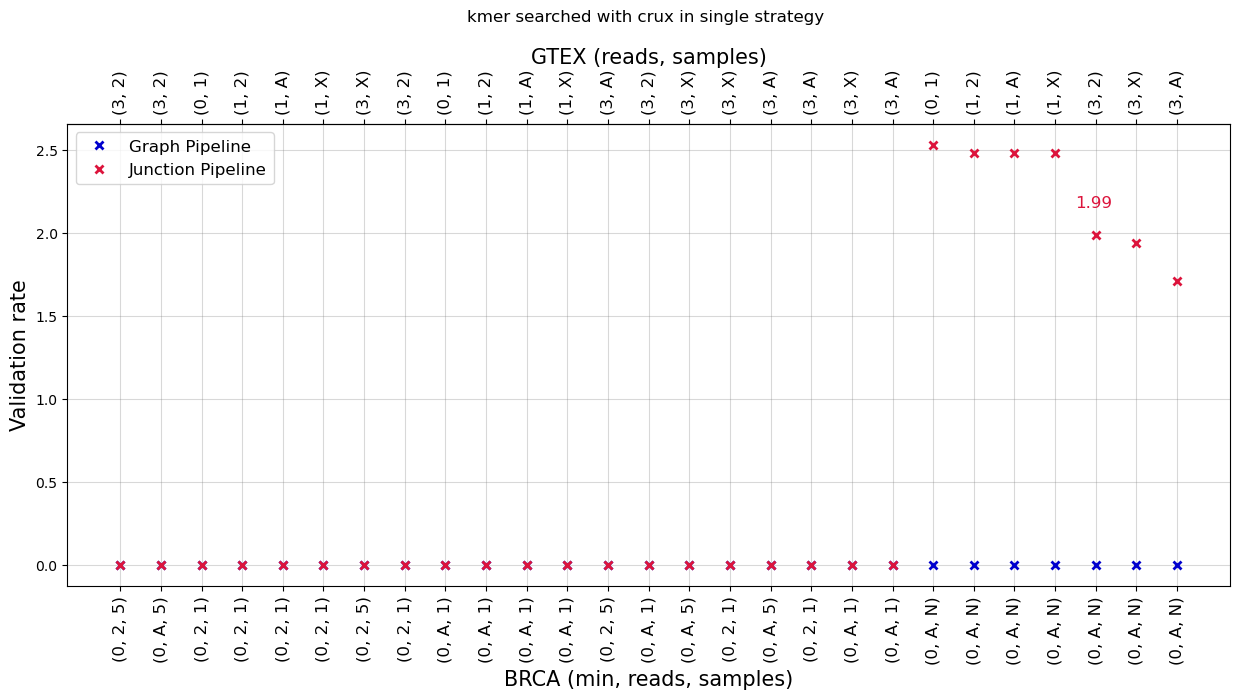

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crux_single.tsv.gz
(54, 19)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_val_rate_tryp-pep_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


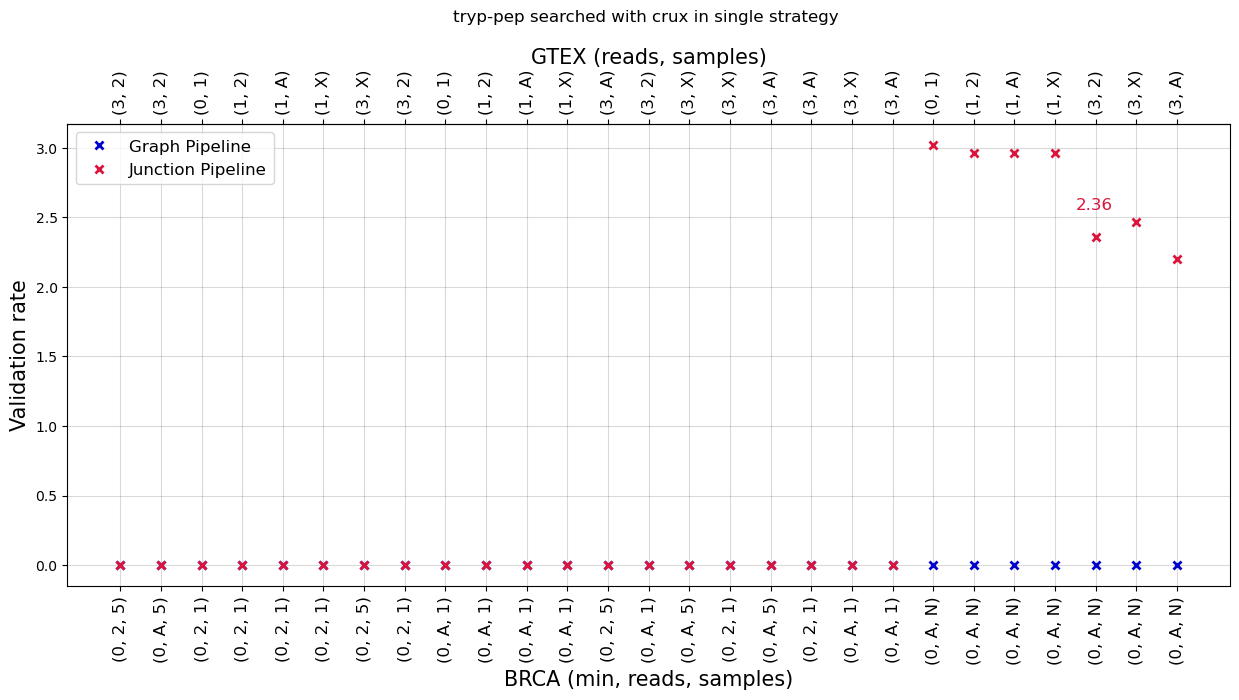

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crux_single.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_kmer_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


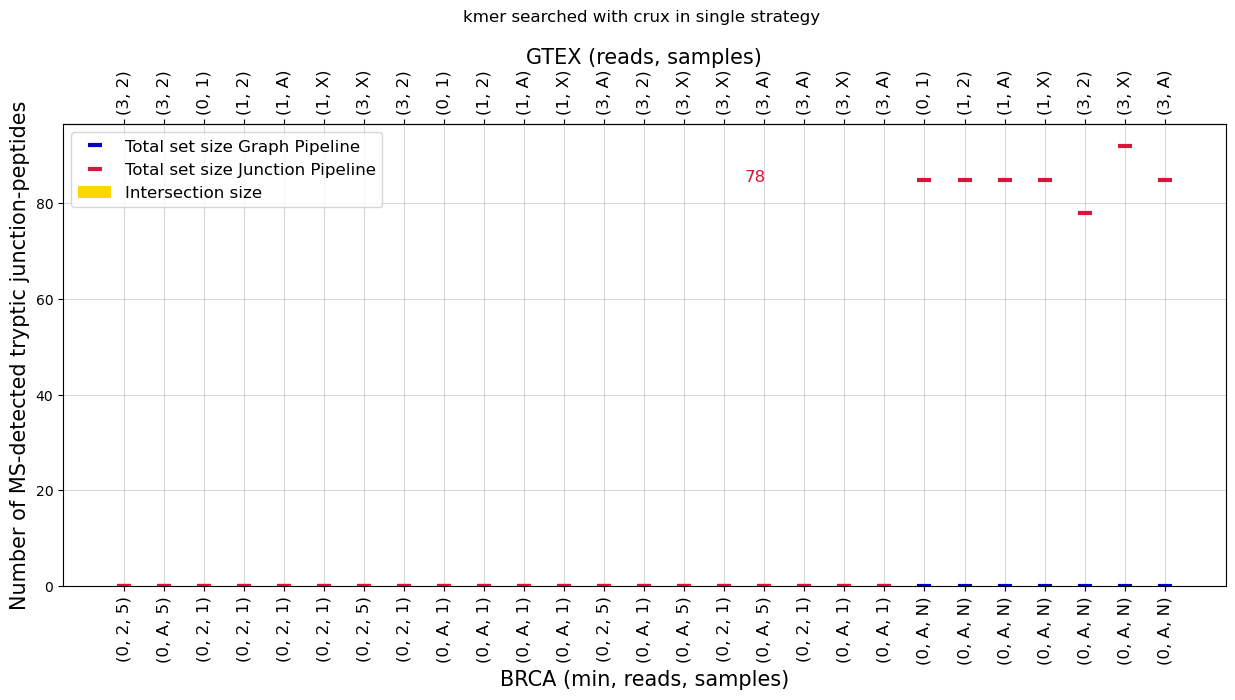

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crux_single.tsv.gz
(27, 22)
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_tryp-pep_crux_single.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:81: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


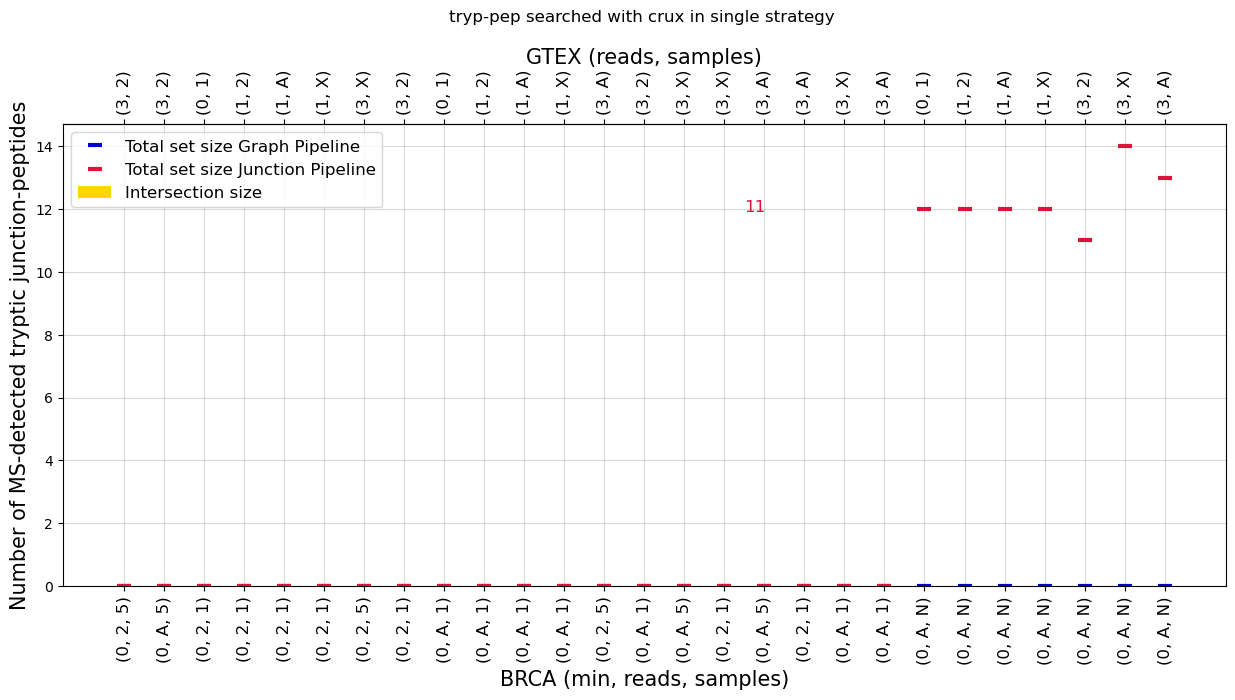

In [7]:
# MAIN 

for MS_FDR in MS_FDR_:
    for MS_strategy in MS_strategy_:
        param_MS.edit_MS( MS_FDR, MS_strategy)
        for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:

            # Intermediate paths filtering
            order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

            # Intermediate data path MS results
            path_data_pep = os.path.join(save_folder, f'data_peptides{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers = os.path.join(save_folder, f'data_kmers{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_peptide_rates = os.path.join(save_folder, f'data_peptides-rates{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers_rates = os.path.join(save_folder, f'data_kmers-rates{MS_FDR}_{MS_strategy}.tsv.gz')


            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers_rates, path_data_peptide_rates]):
                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type="x", marker_size=6, markeredgewidth=2)

                df_plot = run_sample_plotting_rates(order_file, sample, df, param_MS, param_object)

            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers, path_data_pep]):

                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
                df_plot = run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object)
